In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
%matplotlib inline
from datetime import datetime as dt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.cm as cm
from sklearn import linear_model
import json
import logging
FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)
from sklearn.preprocessing import MinMaxScaler

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


## Section 1 -- Import data

In [3]:
# import csv files with wikipedia pageview info and supporting links
df_wiki = pd.read_csv('wikipedia_links.csv',index_col='wiki_url')
df_wiki_links = pd.read_csv('data/wiki_links_data.csv', index_col='wiki_url')
df_wiki_pageviews = pd.read_csv('data/wiki_pageviews_data.csv', index_col=0)
# import csv file with ratings from both RT and metacritic
df_rt = pd.read_csv('data/rottentomatoes_data.csv', index_col='wiki_url')
df_mc = pd.read_csv('data/metacritic_data.csv', index_col='wiki_url')
# import csv file with bomojo box office information for each
df_bomojo = pd.read_csv('data/bomojo_data.csv', index_col='wiki_url')
# import TheMovieDB data including youtube trailer view data
df_tmdb = pd.read_csv('data/themoviedb_data.csv', converters={'genres':json.loads,'credits':json.loads,
                                                              'keywords':json.loads,'production_companies':json.loads,
                                                              'production_countries':json.loads,
                                                              'video_stats':json.loads},header=0, index_col='wiki_url')
df_tmdb = df_tmdb.drop(['adult', 'backdrop_path', 'belongs_to_collection','facebook_id', 'homepage','instagram_id',
             'original_language', 'original_title','poster_path','spoken_languages', 'status','twitter_id','video'],axis=1)

In [4]:
df_bomojo['release_date'] = pd.to_datetime(df_bomojo.release_date)
df_tmdb['release_date'] = pd.to_datetime(df_tmdb.release_date)
df_wiki_pageviews.index = pd.to_datetime(df_wiki_pageviews.index)

## Section 2 -- Join, feature creation

In [5]:
# need to split genres, keywords, production companies
# video stats into seprate dataframe to group and create features
# pull out production country
# scale vote counts
# remove release date and revenue, get that from bomojo
# might look into tf-idf and clustering with tagline

In [6]:
# split genres, keywords and production companies and countries from column / dictionary
genre_rows = []
for i, genres in zip(df_tmdb.index,df_tmdb.genres):
    if isinstance(genres,list):
        for genre in genres:
            genre_rows.append((i, genre['name']))

df_genre = pd.DataFrame(genre_rows,columns=['wiki_url','genre'])
df_genre.set_index('wiki_url',inplace=True)
df_genre = pd.get_dummies(df_genre).groupby('wiki_url').sum()

In [7]:
keyword_rows = []
for i, keywords in zip(df_tmdb.index,df_tmdb.keywords):
    if isinstance(keywords,list):
        for keyword in keywords:
            keyword_rows.append((i, keyword['name']))

df_keyword_stage = pd.DataFrame(keyword_rows,columns=['wiki_url','keyword'])
df_keyword_stage.set_index('wiki_url',inplace=True)
df_keyword = pd.get_dummies(df_keyword_stage).groupby('wiki_url').sum()

In [8]:
prod_rows = []
for i, prods in zip(df_tmdb.index,df_tmdb.production_companies):
    if isinstance(prods,list):
        for prod in prods:
            prod_rows.append((i, prod['name']))

df_prod_cos = pd.DataFrame(prod_rows,columns=['wiki_url','prod_company'])
df_prod_cos.set_index('wiki_url',inplace=True)
df_prod_cos = pd.get_dummies(df_prod_cos).groupby('wiki_url').sum()

In [9]:
prod_co_rows = []
for i, prods in zip(df_tmdb.index,df_tmdb.production_countries):
    if isinstance(prods,list):
        for prod in prods:
            prod_co_rows.append((i, prod['name']))

df_prod_country = pd.DataFrame(prod_co_rows,columns=['wiki_url','prod_country'])
df_prod_country.set_index('wiki_url',inplace=True)
df_prod_country = pd.get_dummies(df_prod_country).groupby('wiki_url').sum()

In [10]:
credit_rows = []
for i, credits in zip(df_tmdb.index,df_tmdb.credits):
    if isinstance(credits,list):
        for credit in credits:
            credit_rows.append((i, credit['name']))

df_credits = pd.DataFrame(credit_rows,columns=['wiki_url','credit_name'])
df_credits.set_index('wiki_url',inplace=True)
df_credits = pd.get_dummies(df_credits).groupby('wiki_url').sum()

In [11]:
# create dataframe of YT video statistics
video_rows = []
for i, videos in zip(df_tmdb.index,df_tmdb.video_stats):
    if isinstance(videos,list):
        for video in videos:
            video['wiki_url'] = i
            video_rows.append(video)

df_video = pd.DataFrame(video_rows)
df_video = df_video.drop(['favoriteCount'],axis=1).set_index('wiki_url')
df_video = df_video.apply(pd.to_numeric)
df_video = df_video.dropna()
df_video = df_video.groupby('wiki_url').agg({'viewCount' : ['count','min','max','mean','median'], 
                                             'commentCount' : ['min','max','mean','median'],
                                             'dislikeCount' : ['min','max','mean','median'],
                                            'likeCount': ['min','max','mean','median']})

In [12]:
# scaling video views
scaler = MinMaxScaler()
df_video[df_video.columns] = scaler.fit_transform(df_video[df_video.columns])

### Clustering TheMovieDB movie information

In [13]:
def join_dataframes(df1, *others):
    new_df = df1
    for df in others:
        new_df = new_df.merge(df,left_index=True, right_index=True) 
    return new_df

In [14]:
from silhouette_scores import silhouette_scores

For n_clusters = 2 The average silhouette_score is : 0.03607360483507036
For n_clusters = 3 The average silhouette_score is : 0.010839767821983311
For n_clusters = 4 The average silhouette_score is : 0.0037435811605239593
For n_clusters = 5 The average silhouette_score is : 0.006185378876906243
For n_clusters = 10 The average silhouette_score is : 0.000724939907486666
For n_clusters = 20 The average silhouette_score is : -0.02380260600111228
For n_clusters = 100 The average silhouette_score is : -0.029409175246489477


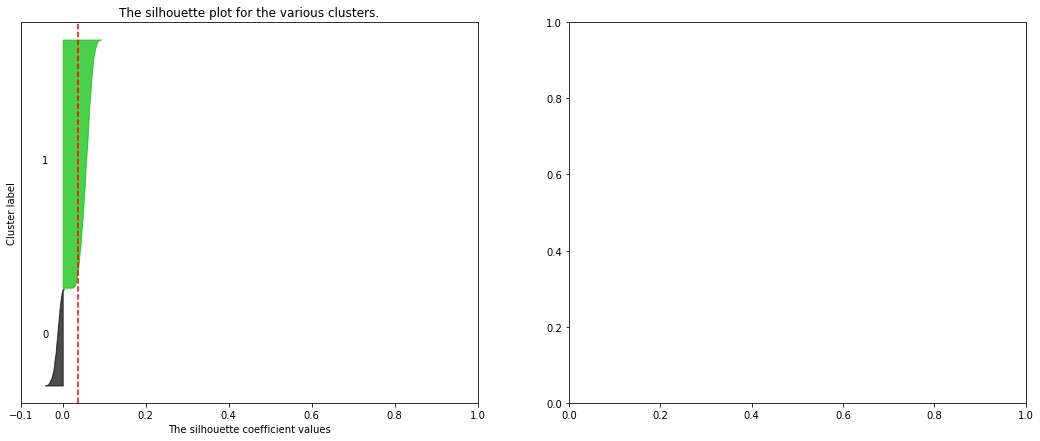

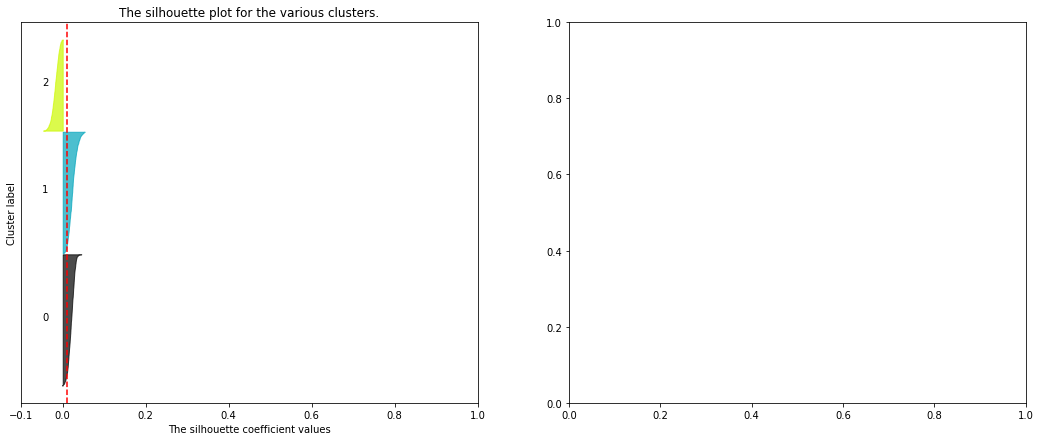

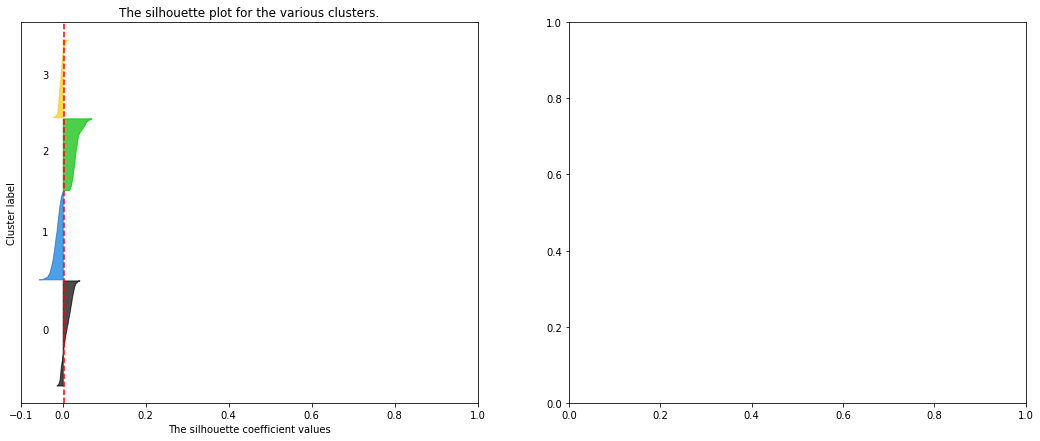

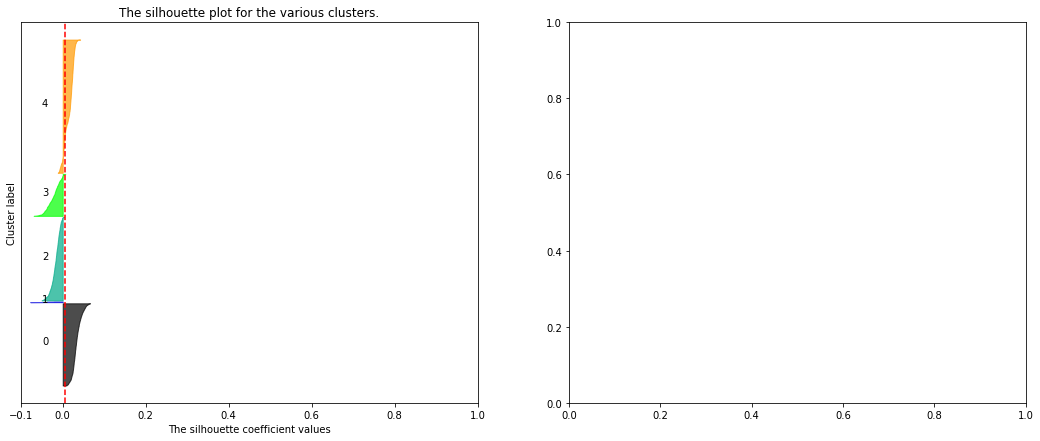

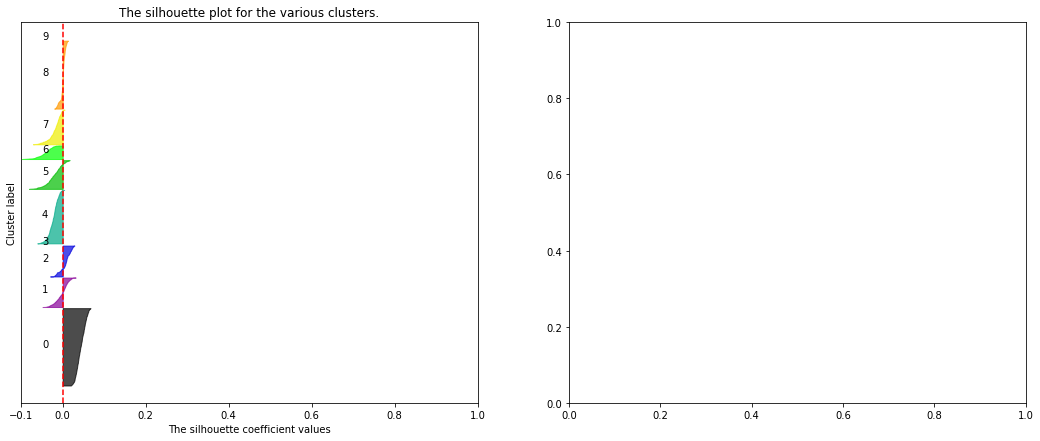

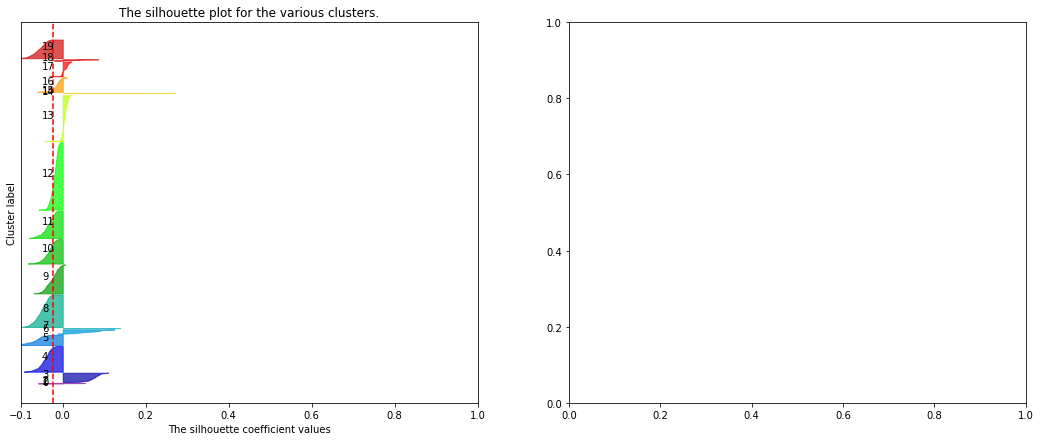

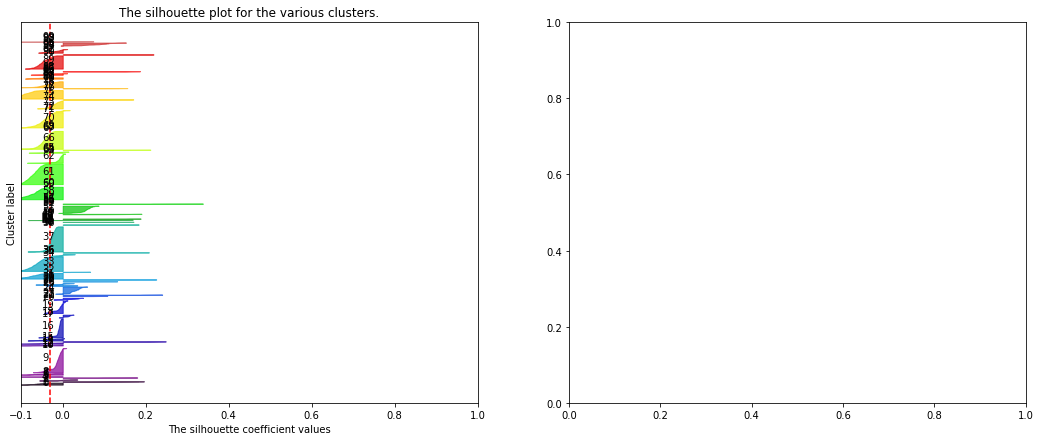

In [15]:
# cluster movie info including credits, keywords, production information
tmdb_cluster = join_dataframes(df_genre,df_prod_cos,df_prod_country,df_keyword,df_credits)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,100]

silhouette_scores(tmdb_cluster, range_n_clusters, KMeans)

Tried KMeans and SpectralClustering with n_clusters from 2-150. None of the options provided very good silhouette scores. I also ran the silhouette scores with and without the actor credits, that didn't help much either. 

Other options for using actor credits:
1. Reduce number of actor credits identified - I first tried 10 actors and moved to 5 to try and limit dimensions
2. Use historical box office prior to a film being released to rank actors money-making power
3. Average the money-making power across all the actors in a film prior to release

For n_clusters = 2 The average silhouette_score is : 0.02449186733505195
For n_clusters = 3 The average silhouette_score is : 0.015071728778186229
For n_clusters = 4 The average silhouette_score is : 0.025902114394976302
For n_clusters = 5 The average silhouette_score is : 3.0384255946146844e-05
For n_clusters = 10 The average silhouette_score is : 0.0009270685487813818
For n_clusters = 20 The average silhouette_score is : -0.04043511974643682
For n_clusters = 30 The average silhouette_score is : -0.04492845176786273
For n_clusters = 100 The average silhouette_score is : -0.015523162249490479


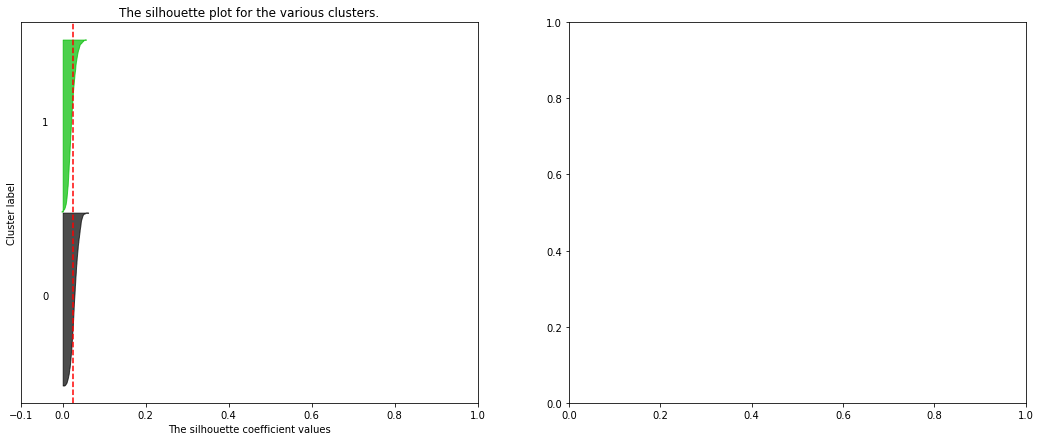

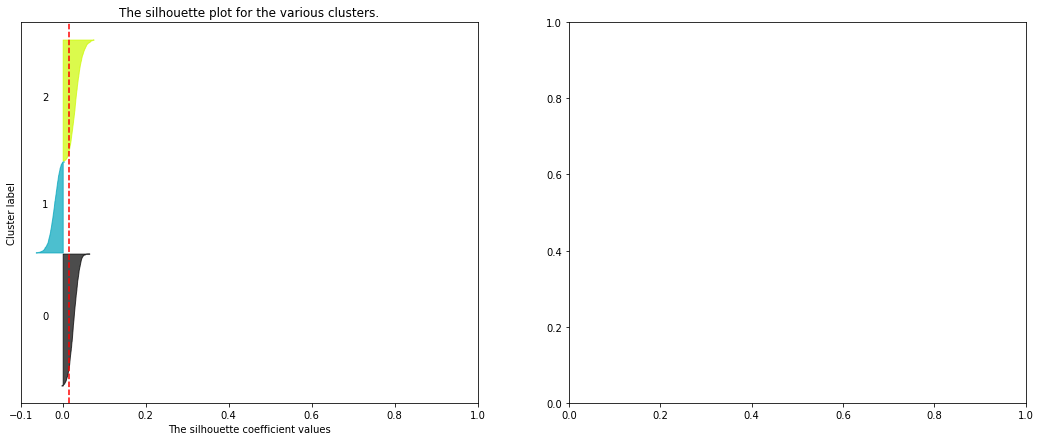

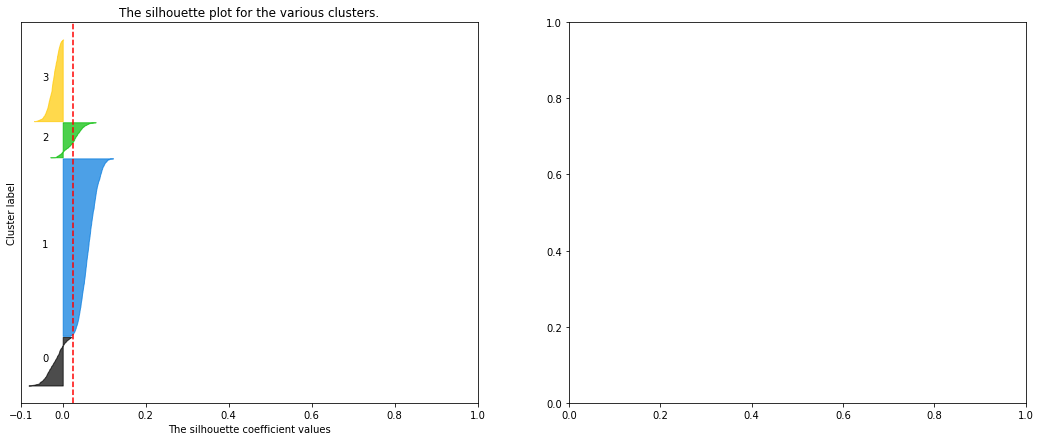

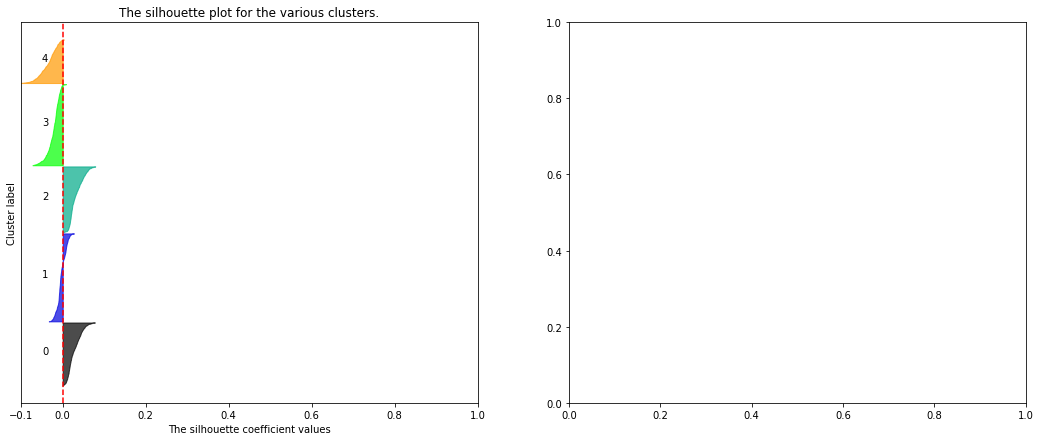

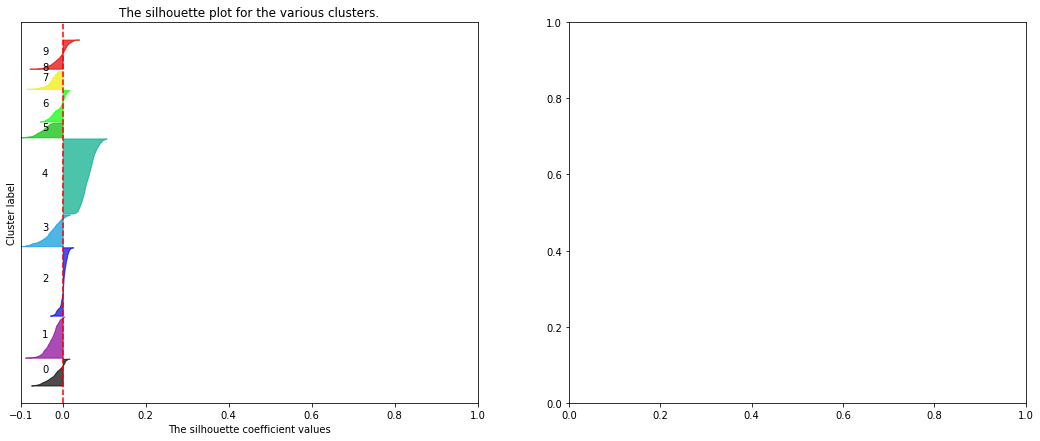

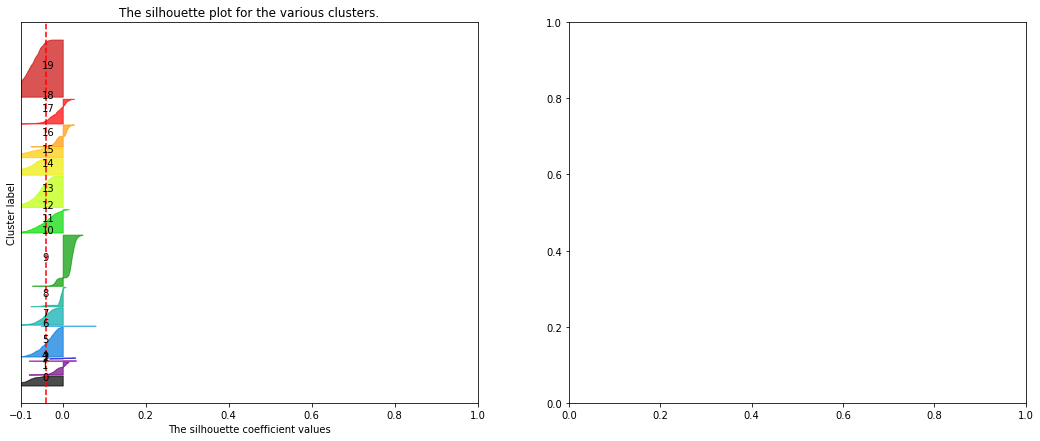

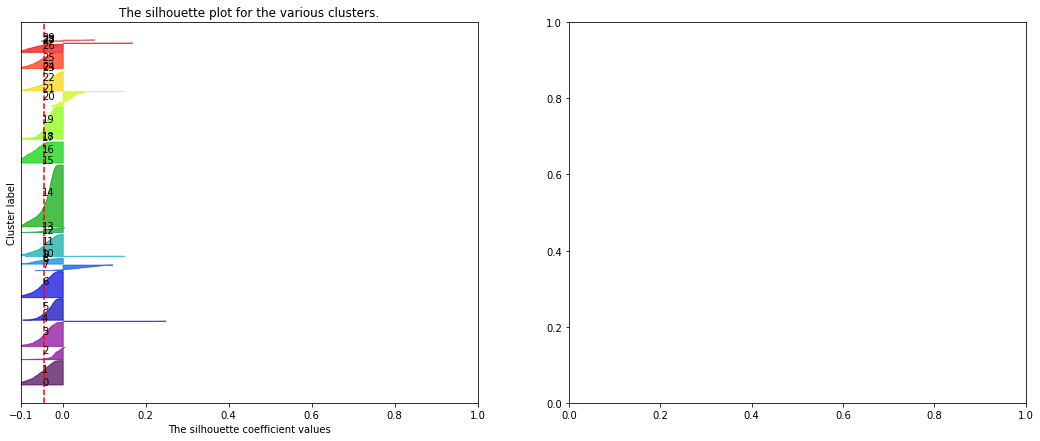

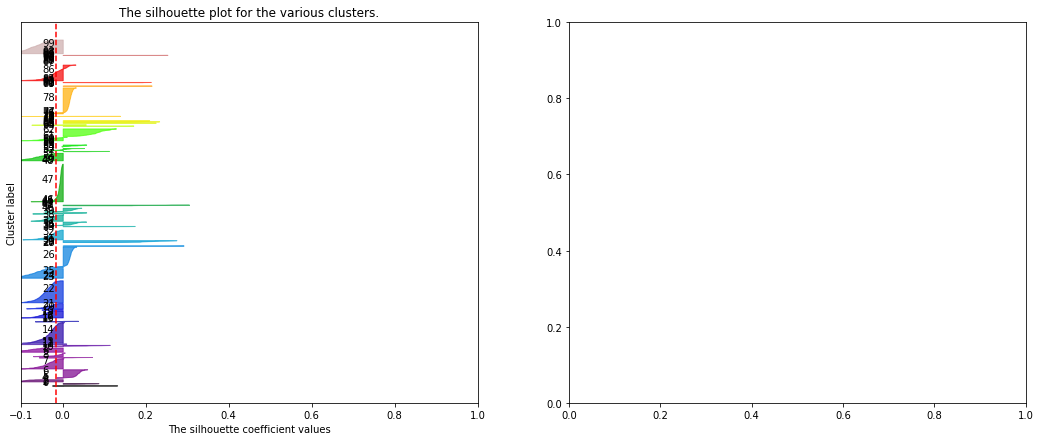

In [16]:
# removed credits with actors
tmdb_cluster = join_dataframes(df_genre,df_prod_cos,df_prod_country,df_keyword)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,30,100]
silhouette_scores(tmdb_cluster, range_n_clusters, KMeans)

For n_clusters = 2 The average silhouette_score is : 0.03590225735382167
For n_clusters = 3 The average silhouette_score is : 0.026976248939031076
For n_clusters = 4 The average silhouette_score is : 0.01542005364820334
For n_clusters = 5 The average silhouette_score is : -0.02127648032462485
For n_clusters = 10 The average silhouette_score is : 0.011362332440405274
For n_clusters = 20 The average silhouette_score is : -0.008120525065296856
For n_clusters = 30 The average silhouette_score is : -0.059343734143419834
For n_clusters = 100 The average silhouette_score is : -0.021658567184386388


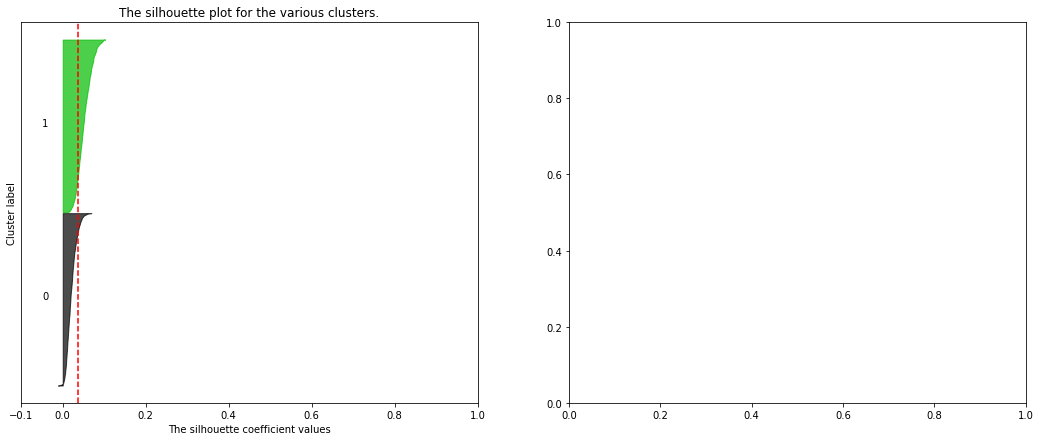

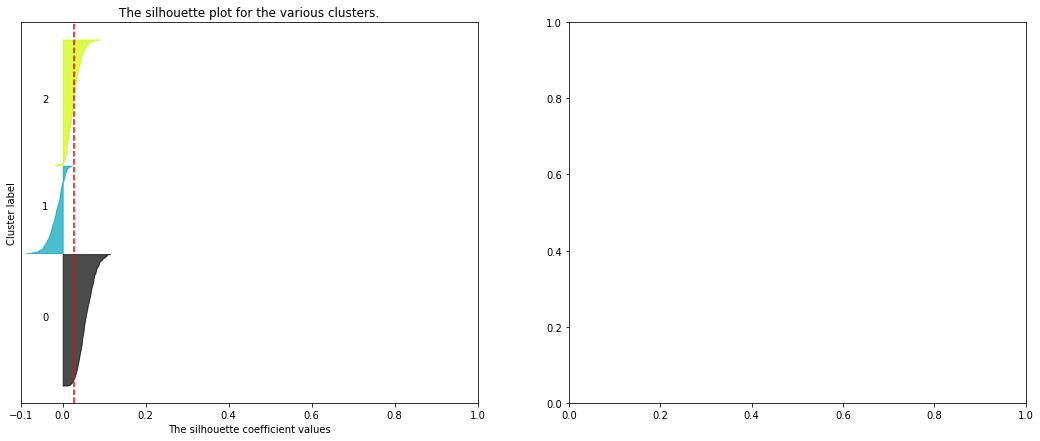

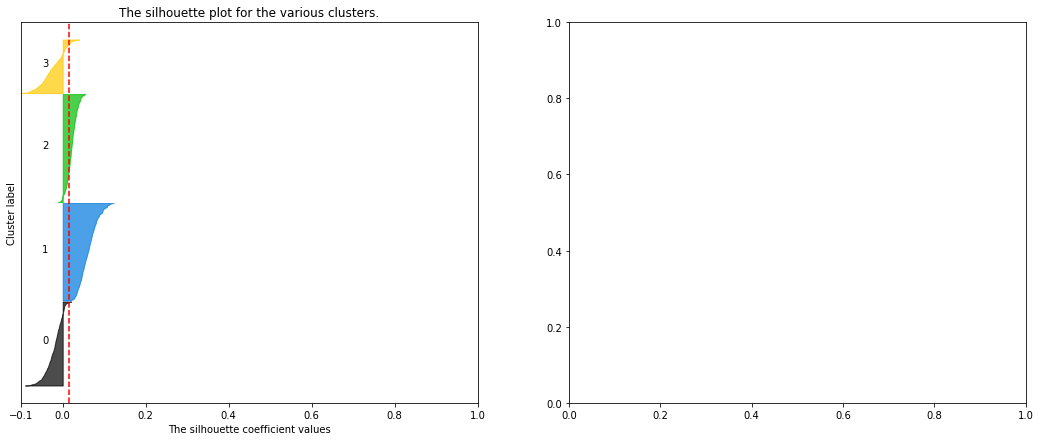

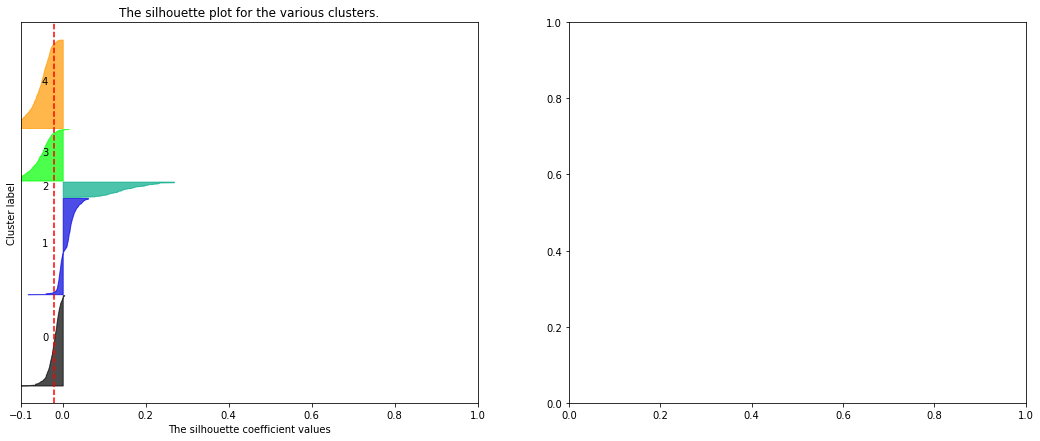

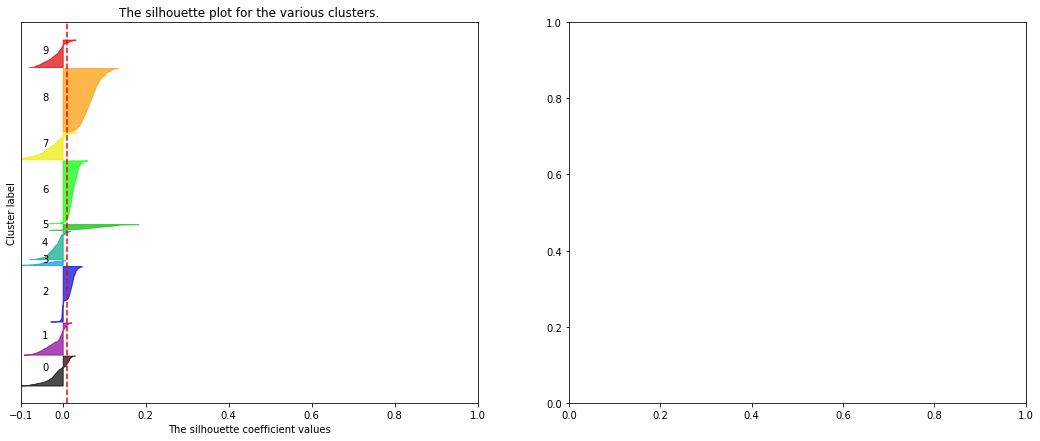

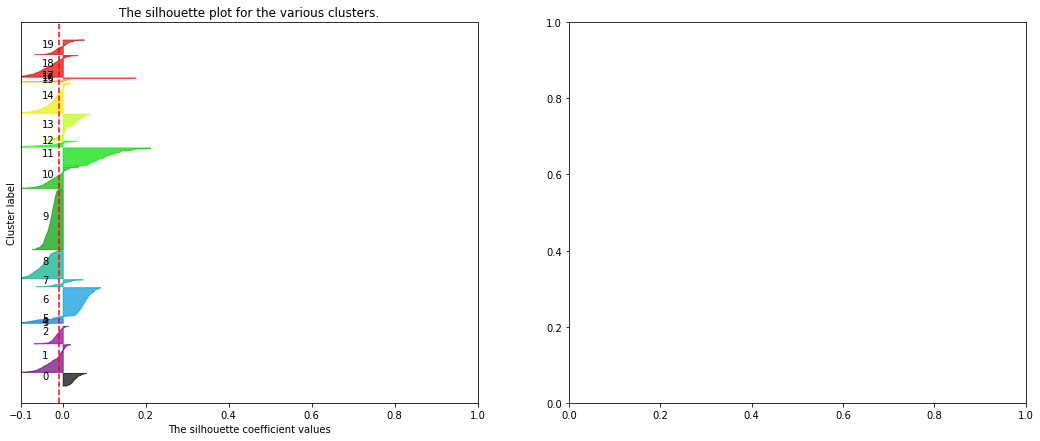

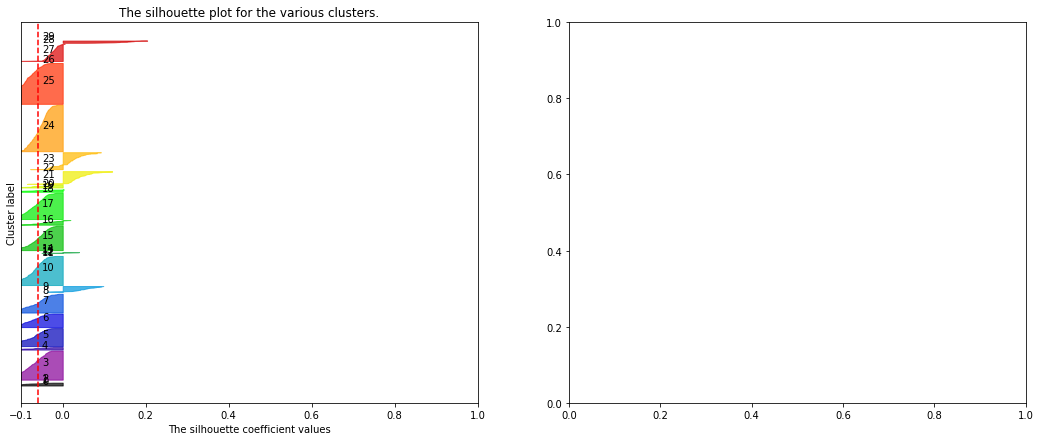

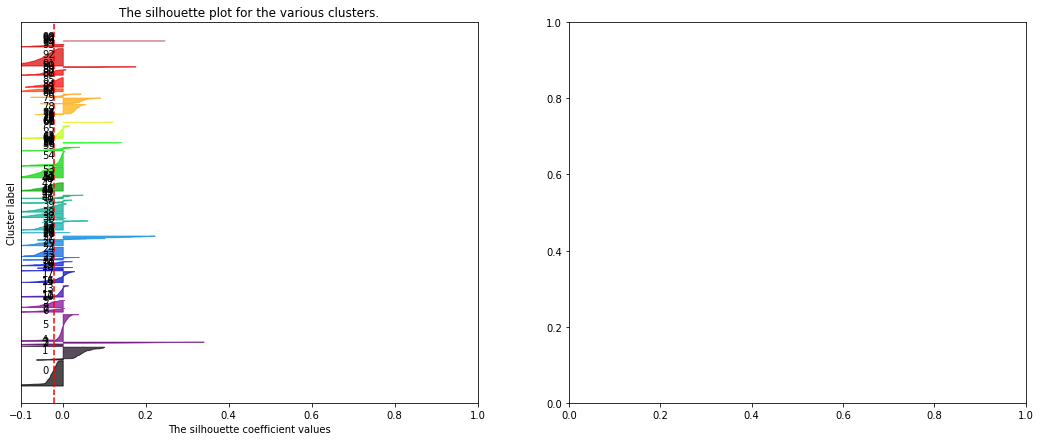

In [17]:
# only looking 
tmdb_cluster = join_dataframes(df_genre,df_keyword)
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,10,20,30,100]
silhouette_scores(tmdb_cluster, range_n_clusters, KMeans)

Better silhouette scores after removing the actor credits, but still not good enough scores to be useful or represent structure within the data. However, removing the actor credits did speed up the clustering process as it removes a ton of dimensions. I will remove actor credits from further analysis and modeling as it doesn't seem to a be a useful indicator. The next iteration of the model I will perhaps only bring the top 3 actor credits instead of top 10.

Same issue when just looking at genres and keywords. I'm surprised by this finding, I expected to find some level of similarity across titles when looking at genre and keywords.

### Clustering on tf_idf of movie keywords and genres

In [18]:
from themoviedb import cluster_movie_keywords

df_keyword_cluster, model, X_tfidf = cluster_movie_keywords(df_keyword_stage,10)

For n_clusters = 2 The average silhouette_score is : 0.01162139690193444
For n_clusters = 3 The average silhouette_score is : 0.011685952104437472
For n_clusters = 4 The average silhouette_score is : 0.01943722384054759
For n_clusters = 5 The average silhouette_score is : 0.018646705877554907
For n_clusters = 10 The average silhouette_score is : 0.02368547385837881
For n_clusters = 20 The average silhouette_score is : 0.027324896628167786
For n_clusters = 30 The average silhouette_score is : 0.03516259891562266
For n_clusters = 40 The average silhouette_score is : 0.038667331296718115
For n_clusters = 60 The average silhouette_score is : 0.03898995189641194
For n_clusters = 80 The average silhouette_score is : 0.04365434219740269
For n_clusters = 100 The average silhouette_score is : 0.046112128171745294


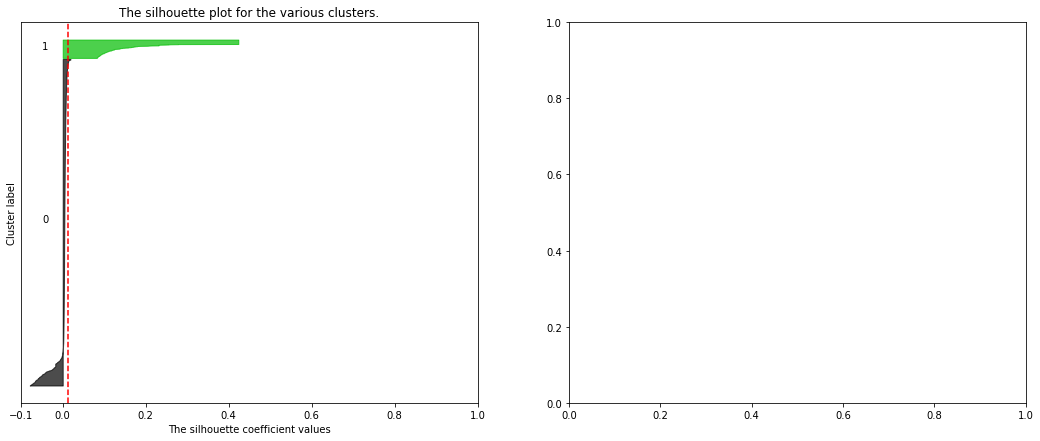

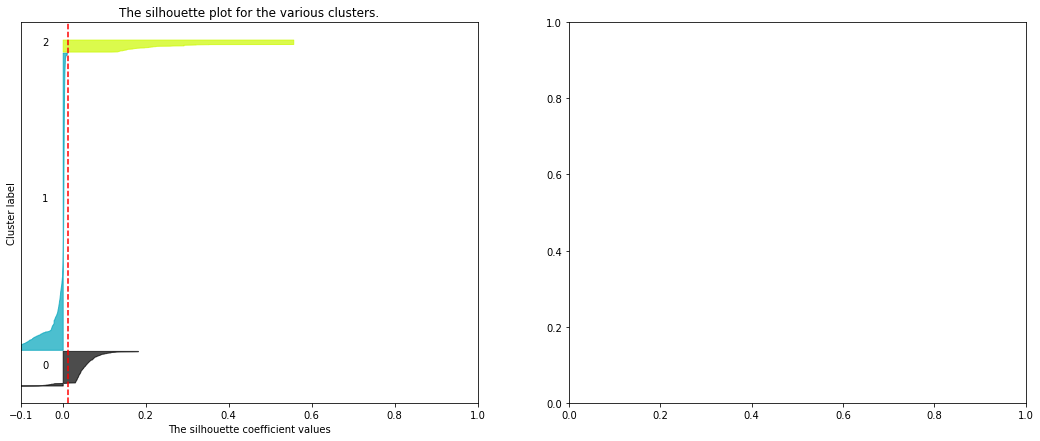

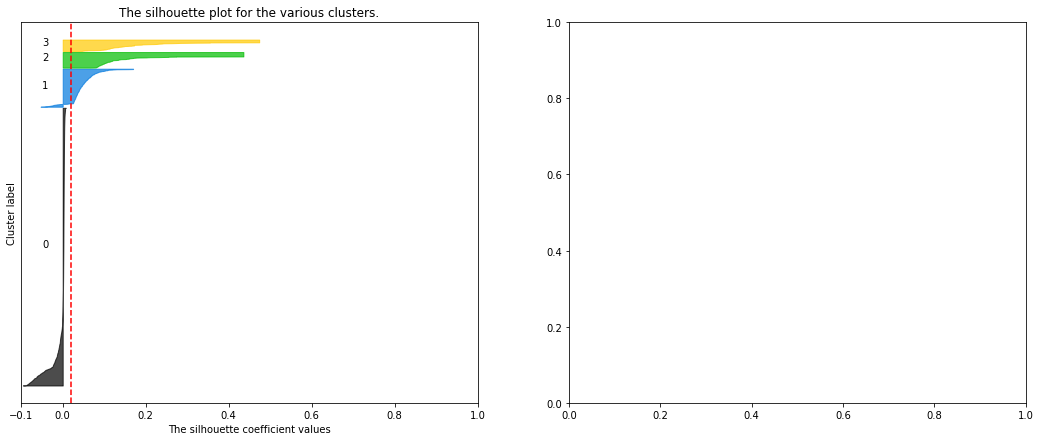

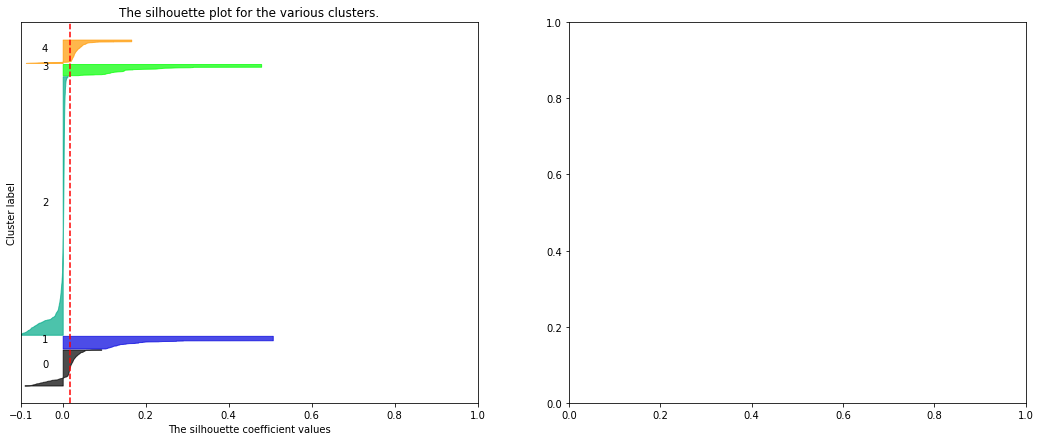

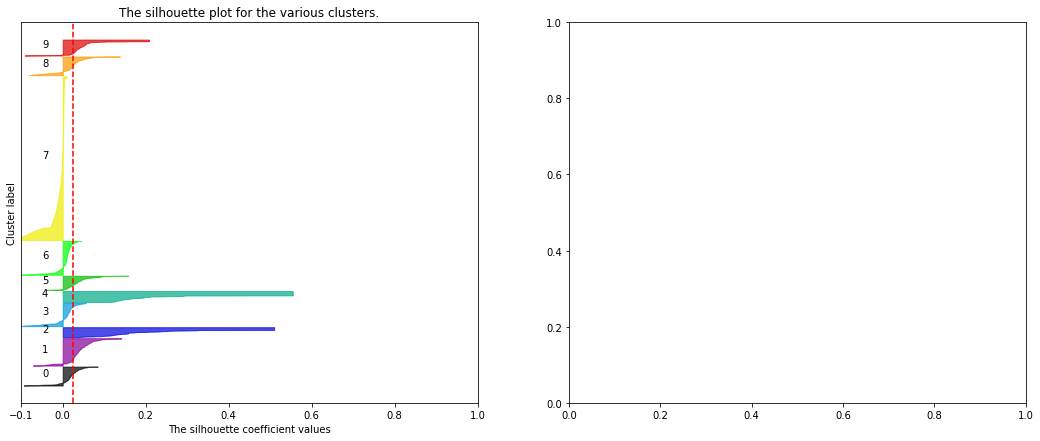

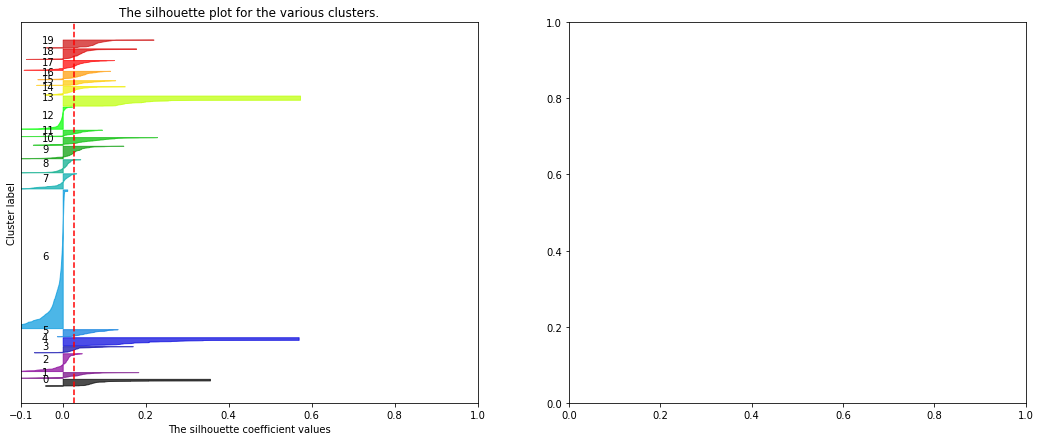

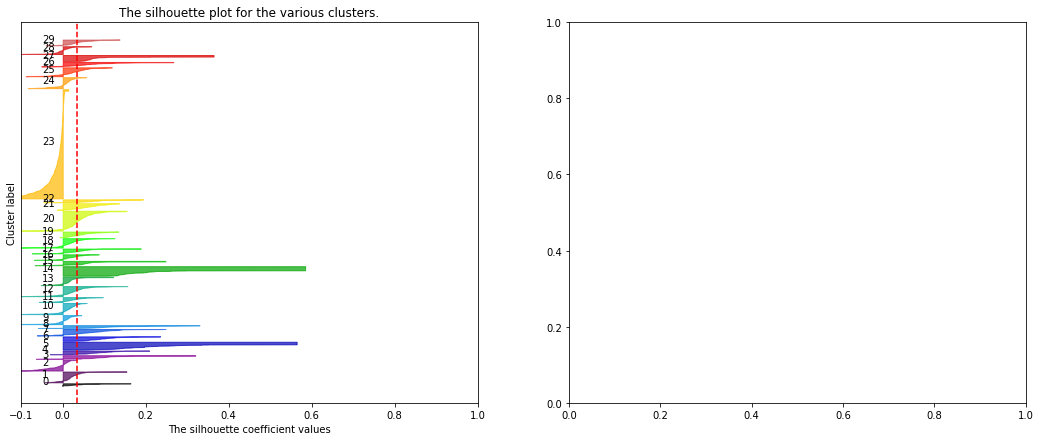

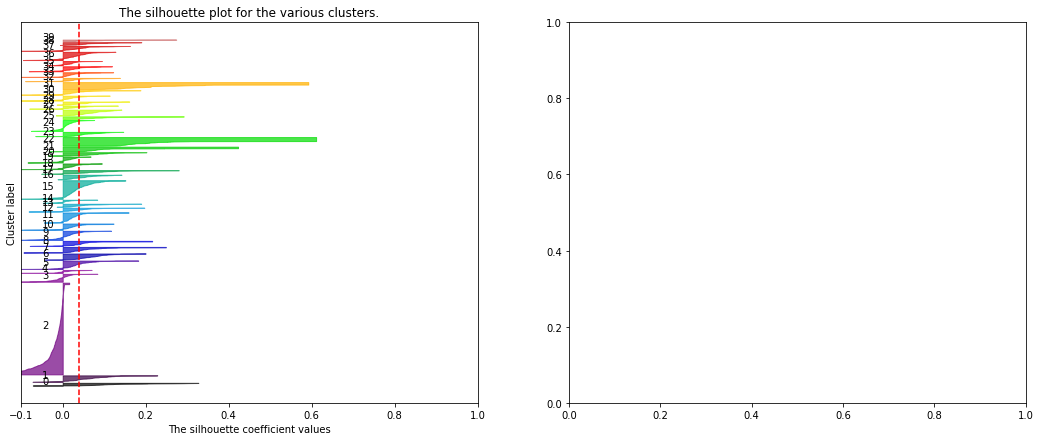

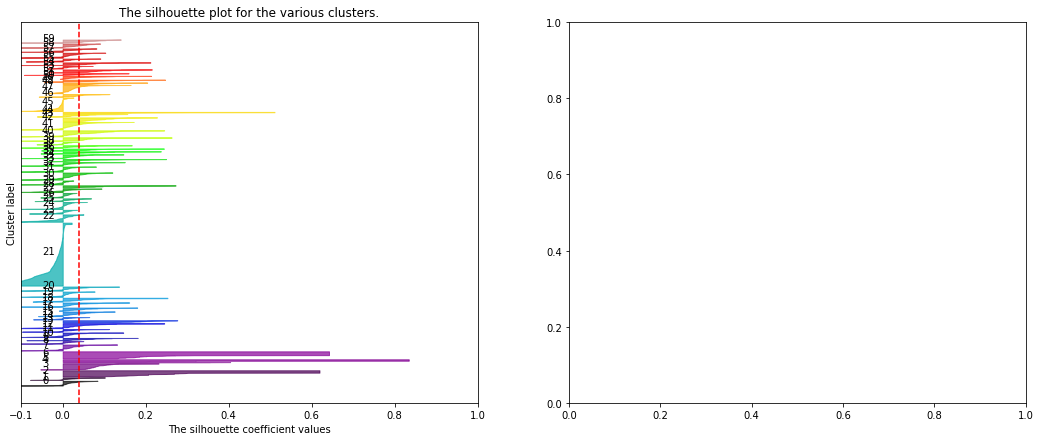

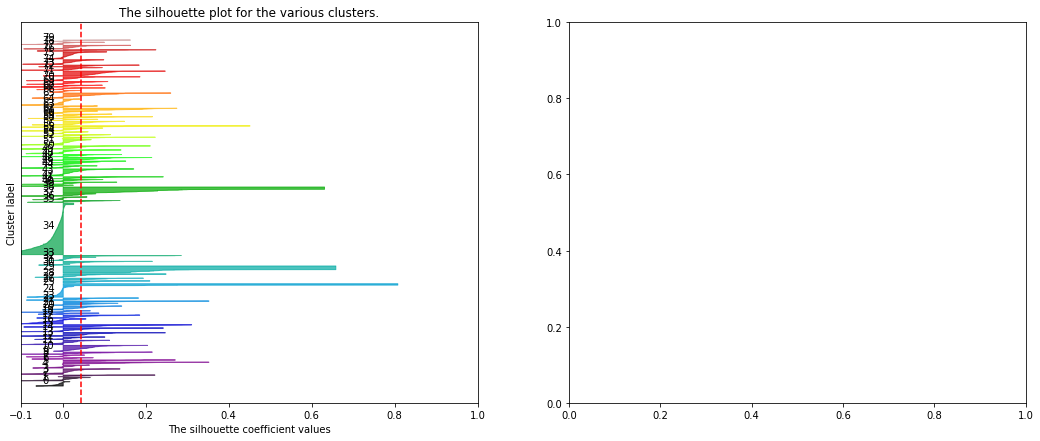

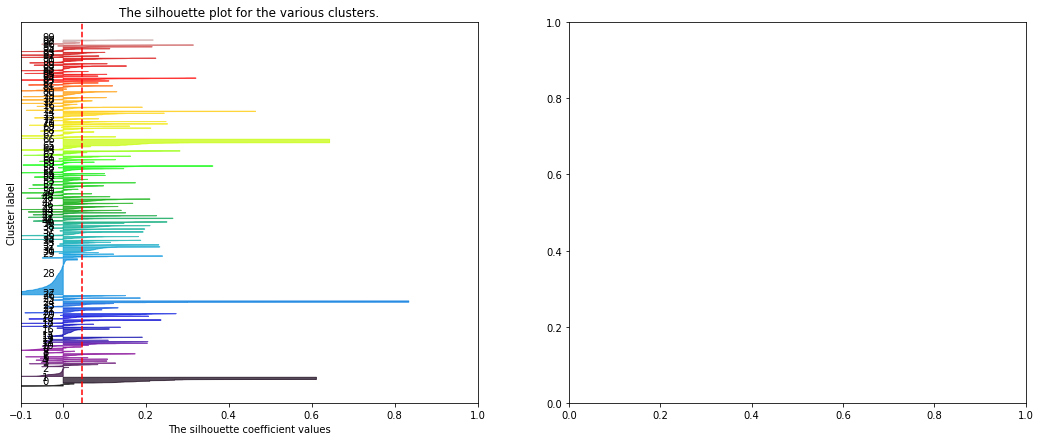

In [19]:
range_n_clusters = [2,3,4,5,10,20,30,40,60,80,100]
silhouette_scores(X_tfidf, range_n_clusters, KMeans)

The code is a little backwards here. However, the silhouette plots / scores determined the number of clusters I used in the keyword cluster. The main motivation here was to cut down on the number of dimensions in my model by clustering keywords after using a tf-idf vectorizer on the all the keywords for a movie. This produced slightly better results than clustering based on keywords alone. 

In [20]:
# merge all separate items back into main df_tmdb dataframe, removing actor credits after clustering findings
# also removing production COMPANIES, will capture this information from bomojo with dstributor
df_tmdb_final = join_dataframes(df_tmdb,df_video,df_genre,df_prod_country,df_keyword_cluster)
df_tmdb_final = df_tmdb_final.drop(['credits','id','imdb_id','genres','keywords','keyword','overview','revenue',
                                    'video_stats','production_companies','production_countries','tagline','title'],axis=1)

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


### Clustering box office mojo information

In [21]:
# filling in any gaps for release dates
df_release = df_bomojo[['release_date']].join(df_tmdb[['release_date']],lsuffix='_x',rsuffix='_y')
df_release['release_date'] = df_release['release_date_x'].fillna(df_release['release_date_y'])
df_bomojo = df_bomojo.join(df_release[['release_date']],rsuffix='_clean')

df_bomojo = df_bomojo.drop('ww_box_office',axis=1).dropna()
df_bomojo['week_number'] = df_bomojo.release_date_clean.dt.week
df_bomojo['week_number'] = pd.Categorical(df_bomojo.week_number)

In [22]:
x = df_bomojo.num_theaters
df_bomojo['scaled_num_theaters'] = (x - x.min())/(x.max() - x.min())
bomojo_cluster = df_bomojo[['genre', 'rating','distributor','week_number', 'scaled_num_theaters']]
bomojo_cluster = pd.get_dummies(bomojo_cluster)

For n_clusters = 2 The average silhouette_score is : 0.0963488245228292
For n_clusters = 3 The average silhouette_score is : 0.12514349256550625
For n_clusters = 4 The average silhouette_score is : 0.1325817822698869
For n_clusters = 5 The average silhouette_score is : 0.09291326956588304
For n_clusters = 6 The average silhouette_score is : 0.0569052407476967
For n_clusters = 7 The average silhouette_score is : 0.06345029887995678
For n_clusters = 8 The average silhouette_score is : 0.07012157857957316
For n_clusters = 9 The average silhouette_score is : 0.07770950686885256
For n_clusters = 10 The average silhouette_score is : 0.08068745231649545
For n_clusters = 20 The average silhouette_score is : 0.09294688098366492
For n_clusters = 30 The average silhouette_score is : 0.10005062581586119
For n_clusters = 100 The average silhouette_score is : 0.08235349689741513


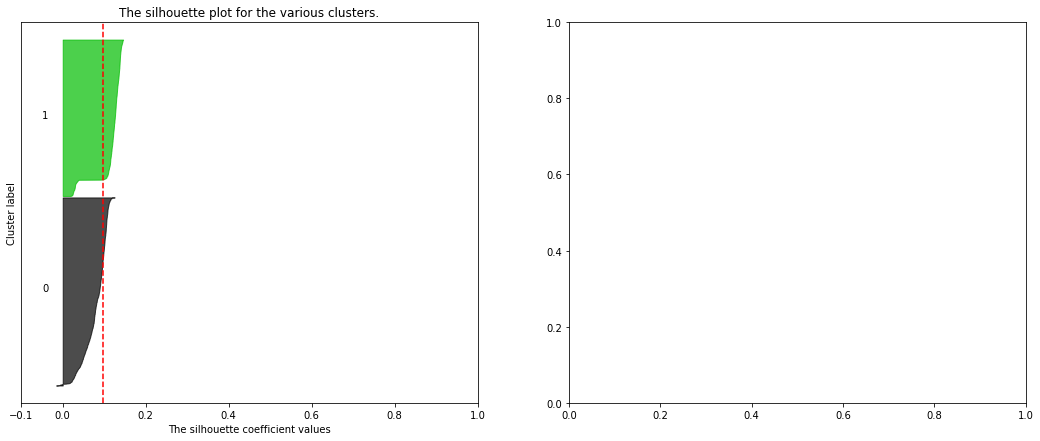

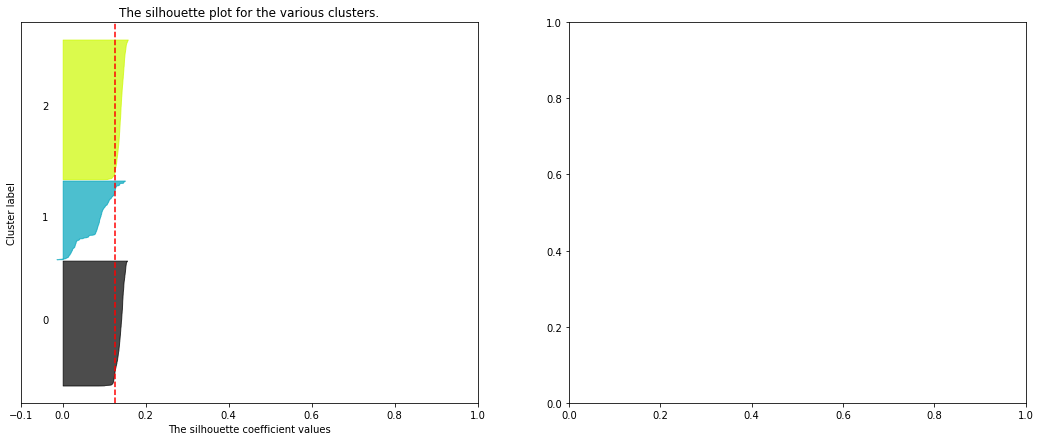

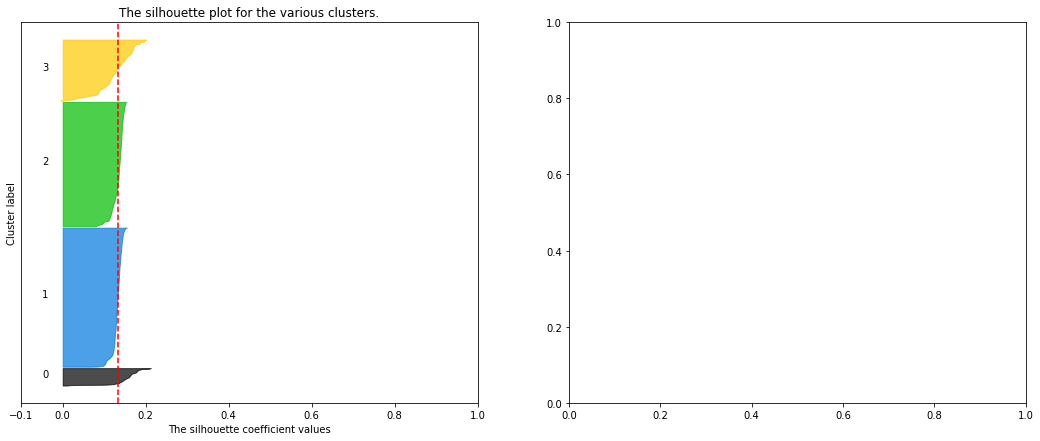

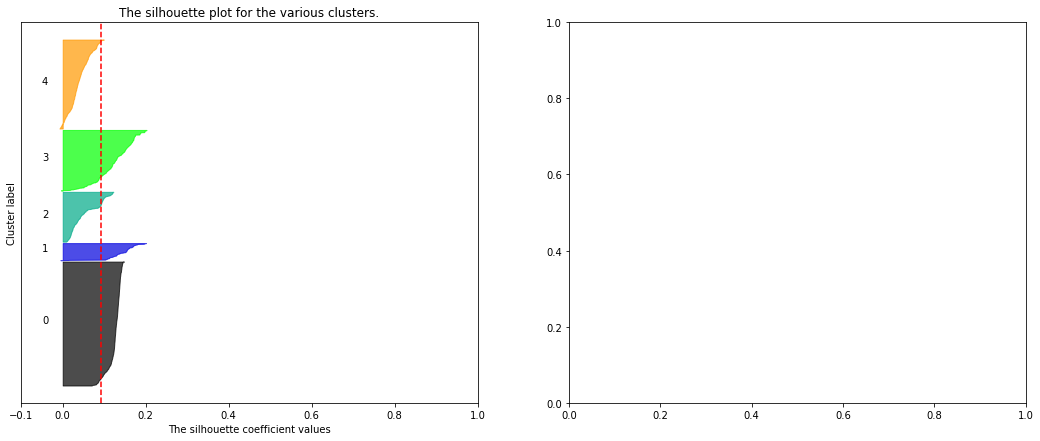

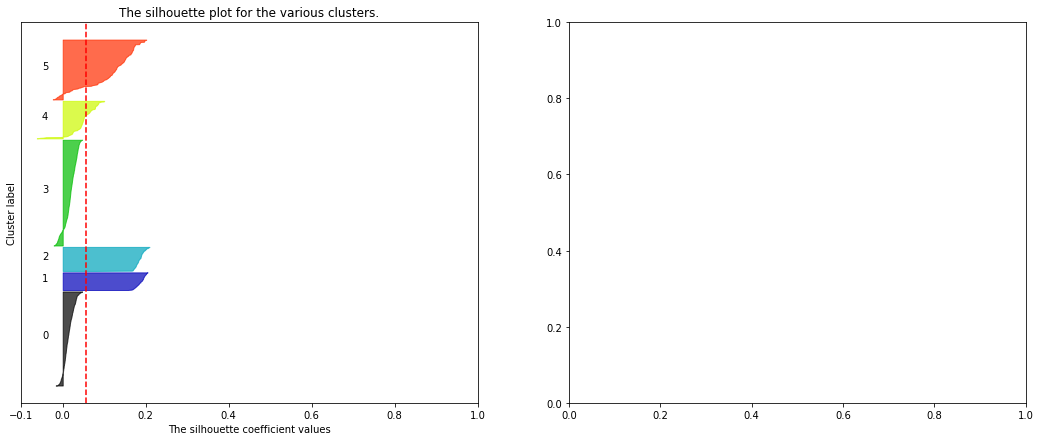

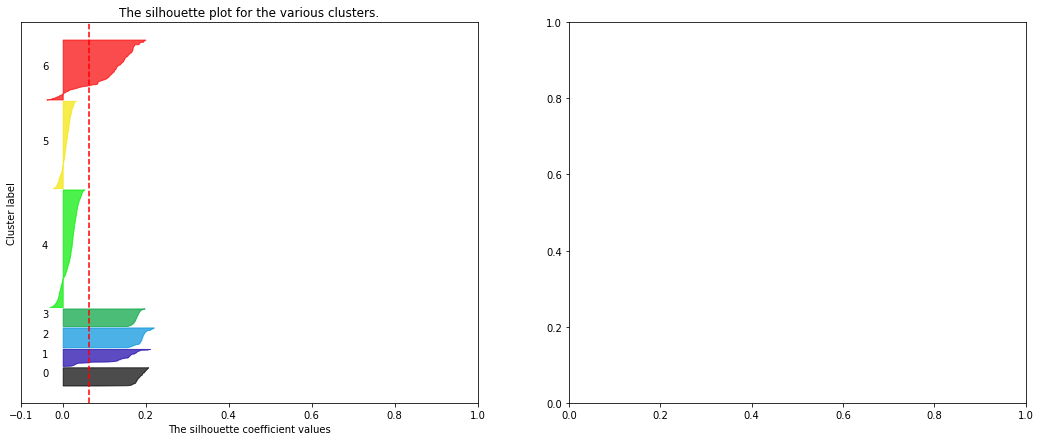

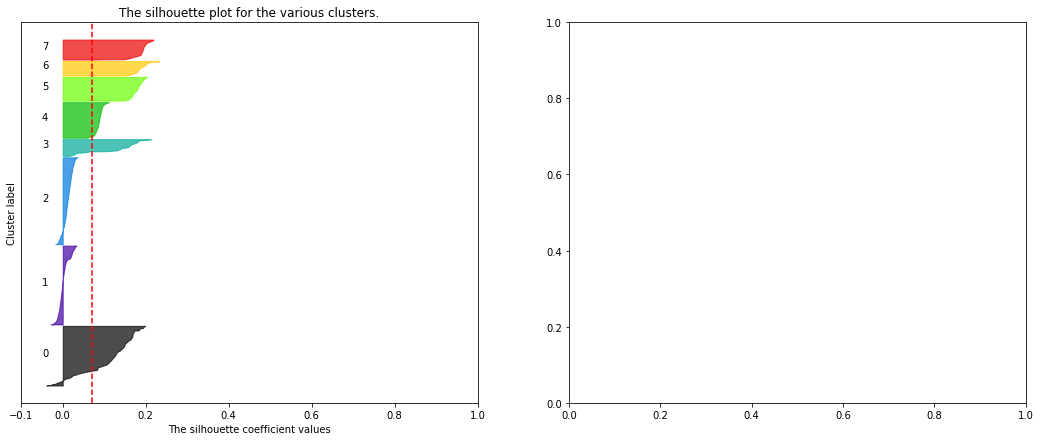

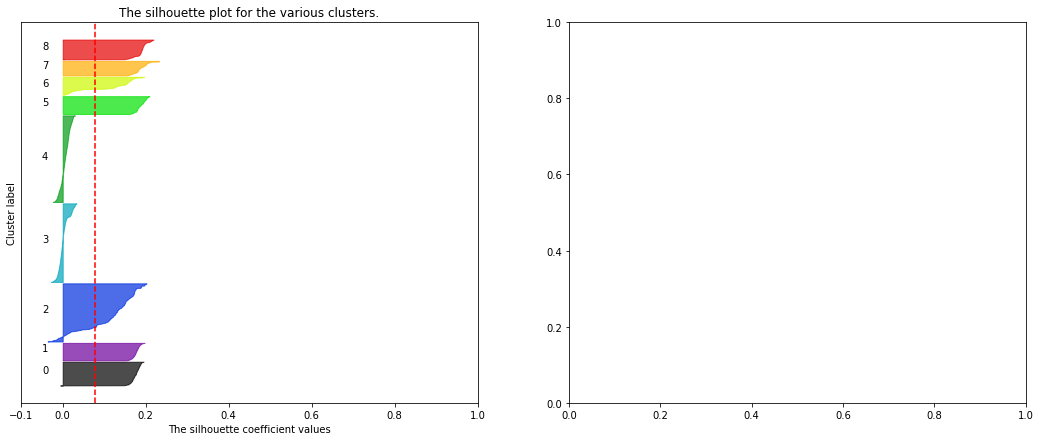

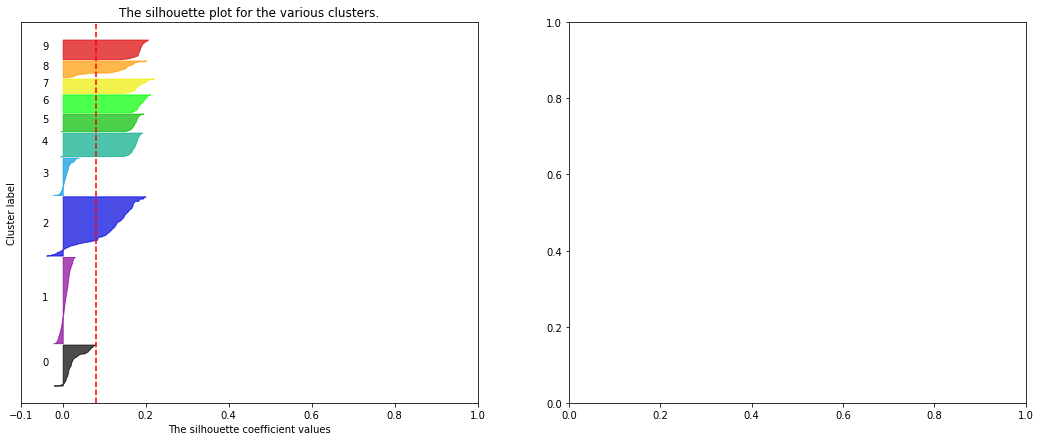

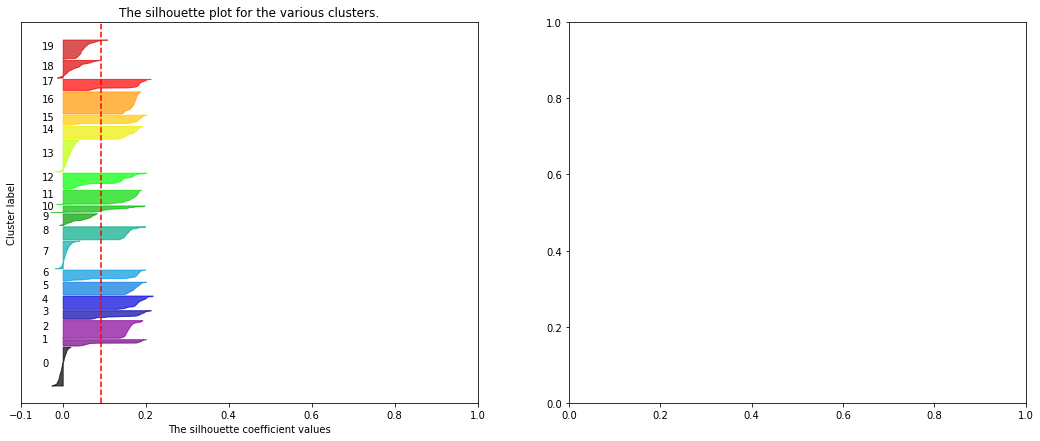

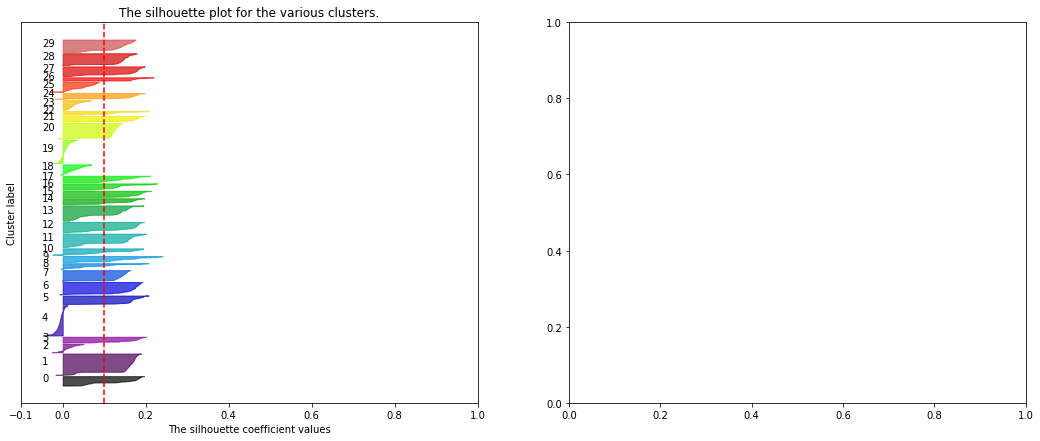

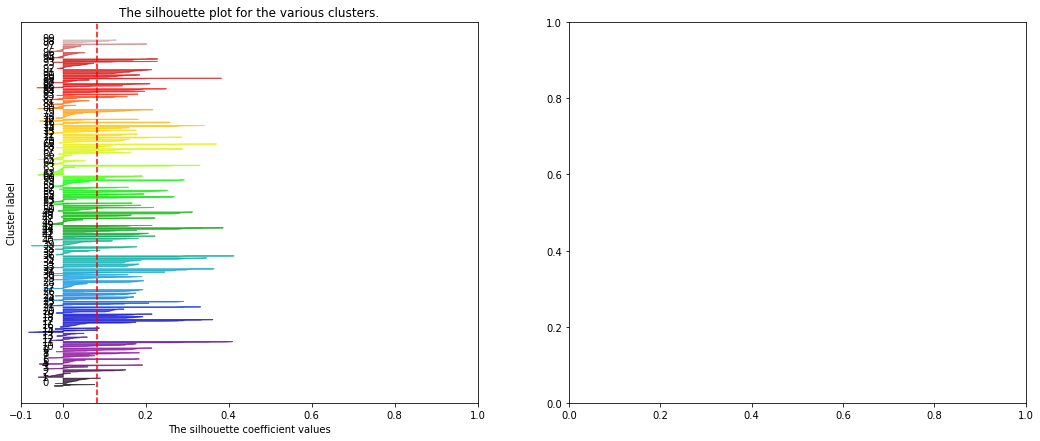

In [23]:
# use silhouette plots for number of cluster identification
range_n_clusters = [2,3,4,5,6,7,8,9,10,20,30,100]
silhouette_scores(bomojo_cluster, range_n_clusters, KMeans)

Chose to go with 4 clusters because that definitely had the highest silhouette score and most distributed silhouette plot. I was getting much different results prior to scaling the number of theaters, which makes sense. The silhouette scores are much worse, because before the unscaled theater values were driving the relationship in the data. 

In [24]:
def scatter_graph(data, x, y, hue):
    plt.figure(figsize=(16,8))
    sns.scatterplot(x=x,y=y,hue=hue,data=data)
    plt.show()

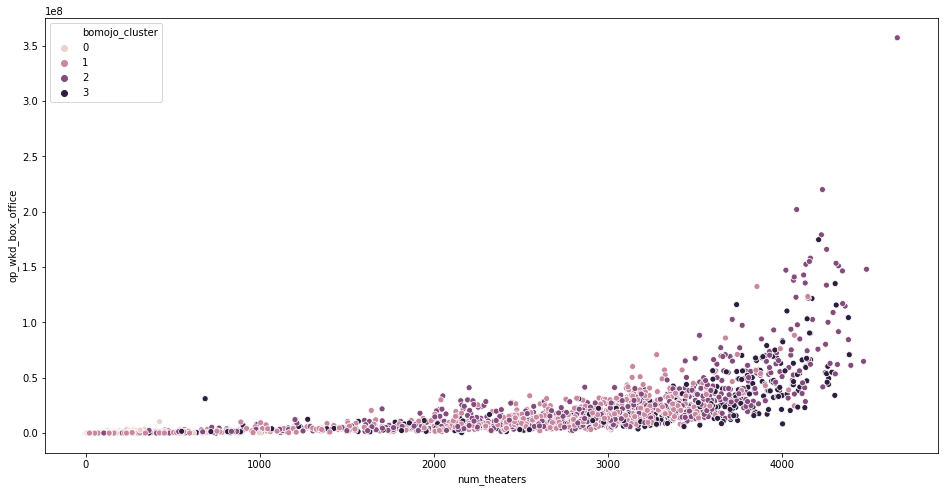

In [25]:
df_bomojo['bomojo_cluster'] =  KMeans(n_clusters=4, random_state=42).fit_predict(bomojo_cluster)
scatter_graph(df_bomojo,'num_theaters','op_wkd_box_office','bomojo_cluster')

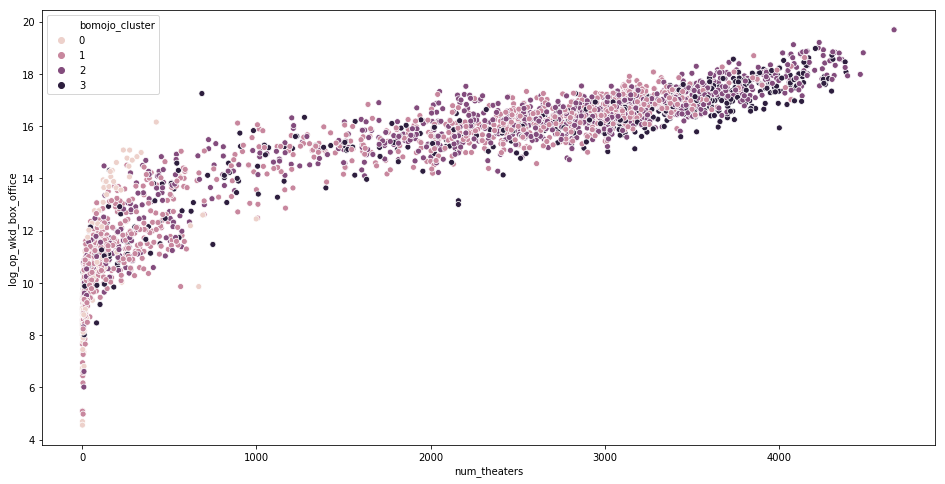

In [26]:
df_bomojo['log_op_wkd_box_office'] = np.log(df_bomojo['op_wkd_box_office'])
scatter_graph(df_bomojo,'num_theaters','log_op_wkd_box_office','bomojo_cluster')                                       

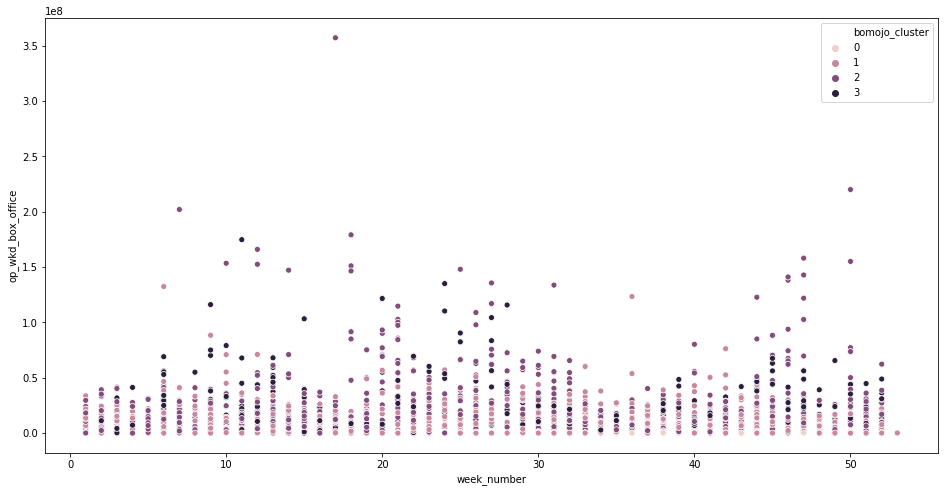

In [27]:
scatter_graph(df_bomojo,'week_number','op_wkd_box_office','bomojo_cluster')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


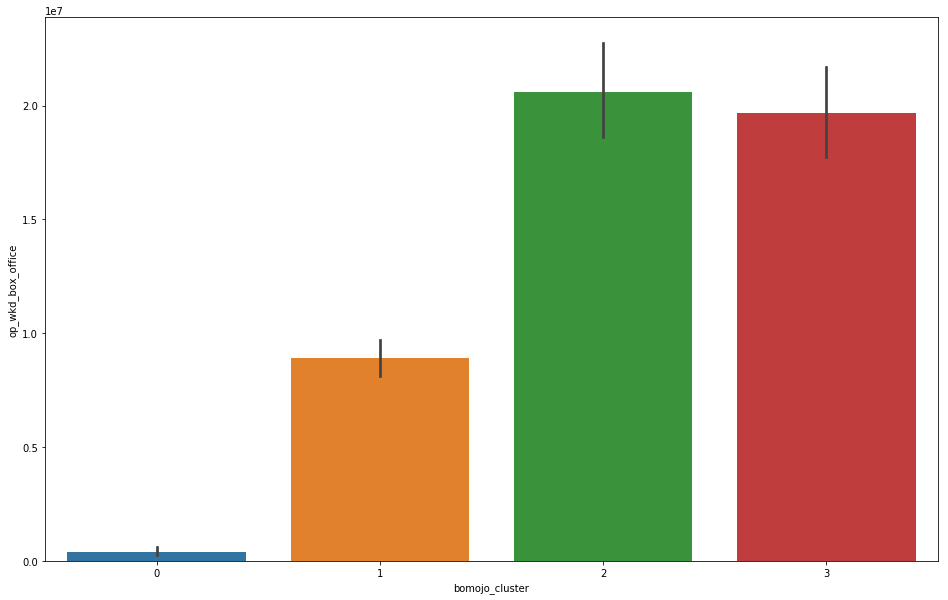

In [28]:
plt.figure(figsize=(16,10))
sns.barplot(x='bomojo_cluster',y='op_wkd_box_office',data=df_bomojo)
plt.show()

### Create wikipedia pageview features

In [29]:
from wikipedia import clean_pageviews

pageviews = []
for url, title in zip(df_wiki.index, df_wiki.clean_wiki_url):
    pageviews.append(clean_pageviews(df_wiki_pageviews, df_release, url, title))

df_pageviews = pd.DataFrame(pageviews).set_index('wiki_url')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Finally, join all dataframe together on wiki_url index. Will drop the columns I don't need before modeling purposes. I would like to run two models for this analysis depending on if that's possible: 

1) WITH pageview features. This limits the number of films to only ~3-4 years worth, but I have more features

2) WITHOUT pageview features. This increases the number of films to 10+ years, but reduces the number of overall features

In [30]:
df_bo_predictor = join_dataframes(df_tmdb_final,df_rt, df_mc, df_bomojo)
df_bo_predictor.to_csv('data/df_bo_predictor.csv',sep=',',index=True)

In [31]:
df_bo_predictor_wpv = join_dataframes(df_tmdb_final,df_rt, df_mc, df_bomojo,df_pageviews)
# df_bo_predictor_wpv.to_csv('data/df_bo_predictor_wpv.csv',sep=',',index=True)

In [32]:
df_bo_predictor_wpv.describe()

,budget,popularity,runtime,vote_average,vote_count,"(viewCount, count)","(viewCount, min)","(viewCount, max)","(viewCount, mean)","(viewCount, median)",...,median_total,median_week_2,median_week_3,median_week_4,std_month_2,std_month_3,std_total,std_week_2,std_week_3,std_week_4
count,2.000000e+00,2.000000,2.000000,2.000000,2.00000,2.0,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.0,1.0,1.0,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
mean,5.000000e+06,10.428000,100.000000,6.650000,1561.00000,0.0,0.126600,0.002877,0.010764,0.117791,...,1407.500000,6900.0,12412.0,4812.0,2627.103203,497.826112,3773.507886,2931.680089,3913.471392,860.781013
std,7.071068e+06,6.587407,7.071068,0.494975,1854.03398,0.0,0.156373,0.003553,0.013295,0.145493,...,1718.976585,NaN,NaN,NaN,NaN,NaN,5165.569243,NaN,NaN,NaN
min,0.000000e+00,5.770000,95.000000,6.300000,250.00000,0.0,0.016028,0.000364,0.001362,0.014912,...,192.000000,6900.0,12412.0,4812.0,2627.103203,497.826112,120.898846,2931.680089,3913.471392,860.781013
25%,2.500000e+06,8.099000,97.500000,6.475000,905.50000,0.0,0.071314,0.001620,0.006063,0.066352,...,799.750000,6900.0,12412.0,4812.0,2627.103203,497.826112,1947.203366,2931.680089,3913.471392,860.781013
50%,5.000000e+06,10.428000,100.000000,6.650000,1561.00000,0.0,0.126600,0.002877,0.010764,0.117791,...,1407.500000,6900.0,12412.0,4812.0,2627.103203,497.826112,3773.507886,2931.680089,3913.471392,860.781013
75%,7.500000e+06,12.757000,102.500000,6.825000,2216.50000,0.0,0.181886,0.004133,0.015464,0.169230,...,2015.250000,6900.0,12412.0,4812.0,2627.103203,497.826112,5599.812406,2931.680089,3913.471392,860.781013
max,1.000000e+07,15.086000,105.000000,7.000000,2872.00000,0.0,0.237172,0.005389,0.020165,0.220670,...,2623.000000,6900.0,12412.0,4812.0,2627.103203,497.826112,7426.116926,2931.680089,3913.471392,860.781013


At the moment, unable to figure out why the wiki_pageview data is not matching up to the other tables. I will have to remove the wikipedia pageview data entirely from the analysis.

In [33]:
# at some point, look to either scaling pageview data or using PCA for pageview data
# and run model with that versus clustering

### Final dataframe and visualizations
(Can bypass above if you have already saved final dataframe, read csv below)

In [34]:
df_bo_predictor = pd.read_csv('data/df_bo_predictor.csv', index_col='wiki_url')
# df_bo_predictor_wpv = pd.read_csv('data/df_bo_predictor_wpv.csv', index_col='wiki_url')

In [35]:
# create additional metric to predict: film multiple which is the total film performance divided by
# its opening weekend performance
df_bo_predictor['film_multiple'] = df_bo_predictor.dom_box_office / df_bo_predictor.op_wkd_box_office
# df_bo_predictor_wpv['film_multiple'] = df_bo_predictor_wpv.dom_box_office / df_bo_predictor_wpv.op_wkd_box_office

In [36]:
df_bo_predictor.head()

,budget,popularity,release_date_x,runtime,vote_average,vote_count,"('viewCount', 'count')","('viewCount', 'min')","('viewCount', 'max')","('viewCount', 'mean')",...,op_wkd_box_office,rating,release_date_y,title,release_date_clean,week_number,scaled_num_theaters,bomojo_cluster,log_op_wkd_box_office,film_multiple
wiki_url,,,,,,,,,,,,,,,,,,,,,
/wiki/Coach_Carter,30000000.0,8.976,2005-01-14,136.0,7.4,1005.0,0.0,0.035484,0.000806,0.003017,...,24182961.0,PG-13,2005-01-14,Coach Carter,2005-01-14,2,0.552027,2,17.001159,2.781499
/wiki/Racing_Stripes,30000000.0,7.432,2005-01-06,102.0,5.3,271.0,0.0,0.002147,0.000049,0.000182,...,13920052.0,PG,2005-01-14,Racing Stripes,2005-01-14,2,0.683115,3,16.448841,3.575599
/wiki/Assault_on_Precinct_13_(2005_film),30000000.0,8.737,2005-01-19,109.0,6.1,493.0,0.0,0.012267,0.000279,0.001043,...,6502724.0,R,2005-01-19,Assault on Precinct 13,2005-01-19,3,0.492598,1,15.687732,3.081923
/wiki/Alone_in_the_Dark_(2005_film),20000000.0,6.429,2005-01-28,96.0,3.1,279.0,0.0,0.006869,0.000156,0.000584,...,2834421.0,R,2005-01-28,Alone in the Dark,2005-01-28,4,0.455482,1,14.857348,1.827029
/wiki/Hide_and_Seek_(2005_film),30000000.0,6.979,2005-01-27,101.0,6.3,793.0,0.0,0.076896,0.001747,0.006538,...,21959233.0,R,2005-01-28,Hide and Seek,2005-01-28,4,0.644497,1,16.904698,2.327062


In [37]:
df_bo_predictor.describe()

,budget,popularity,runtime,vote_average,vote_count,"('viewCount', 'count')","('viewCount', 'min')","('viewCount', 'max')","('viewCount', 'mean')","('viewCount', 'median')",...,critic_score,score,dom_box_office,num_theaters,op_wkd_box_office,week_number,scaled_num_theaters,bomojo_cluster,log_op_wkd_box_office,film_multiple
count,1.274000e+03,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000,...,1274.000000,1043.000000,1.274000e+03,1274.000000,1.274000e+03,1274.000000,1274.000000,1274.000000,1274.000000,1274.000000
mean,4.184588e+07,10.143774,106.281790,6.228022,1590.824961,0.030289,0.037434,0.001380,0.003932,0.040647,...,49.347724,52.836050,5.184583e+07,2198.866562,1.617974e+07,26.506279,0.471544,1.705651,15.185191,7.474448
std,4.898310e+07,5.158561,17.992227,0.765625,2054.714943,0.086146,0.080789,0.003112,0.007527,0.078094,...,27.043983,16.636712,6.440484e+07,1323.042073,1.994520e+07,14.690375,0.283854,0.801912,2.573783,15.898384
min,0.000000e+00,0.600000,39.000000,3.100000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,7.000000,3.622000e+03,1.000000,4.780000e+02,1.000000,0.000000,0.000000,6.169611,1.000000
25%,7.475000e+06,7.136000,94.000000,5.800000,327.250000,0.000000,0.001378,0.000090,0.000295,0.002633,...,26.000000,41.000000,6.688150e+06,902.750000,1.857652e+06,14.000000,0.193467,1.000000,14.434628,2.431943
50%,2.500000e+07,8.979000,104.000000,6.200000,794.000000,0.000000,0.007904,0.000372,0.001182,0.011315,...,49.000000,53.000000,3.170940e+07,2662.500000,1.055789e+07,27.000000,0.571015,2.000000,16.172376,3.060639
75%,5.775000e+07,12.229750,114.000000,6.700000,1974.750000,0.058824,0.034996,0.001347,0.004031,0.040791,...,73.000000,65.000000,6.999759e+07,3175.000000,2.165840e+07,39.000000,0.680970,2.000000,16.890902,4.300391
max,3.800000e+08,70.351000,338.000000,8.400000,15599.000000,1.000000,1.000000,0.062168,0.085024,0.930421,...,100.000000,96.000000,4.246680e+08,4468.000000,1.580743e+08,53.000000,0.958378,3.000000,18.878576,208.463361


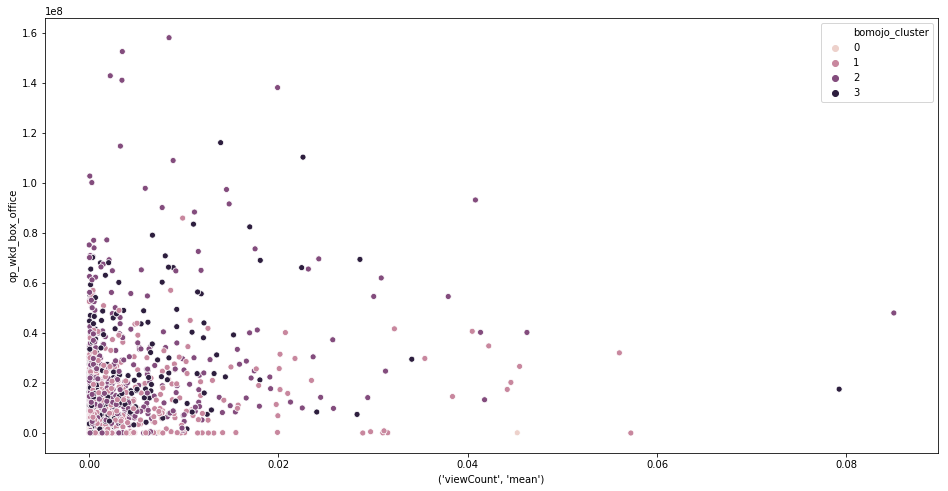

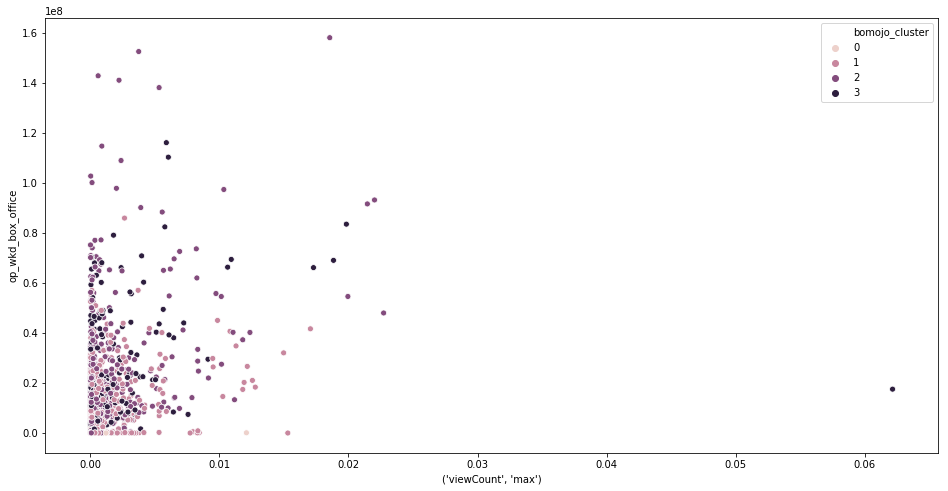

In [38]:
scatter_graph(df_bo_predictor,"('viewCount', 'mean')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('viewCount', 'max')",'op_wkd_box_office','bomojo_cluster')

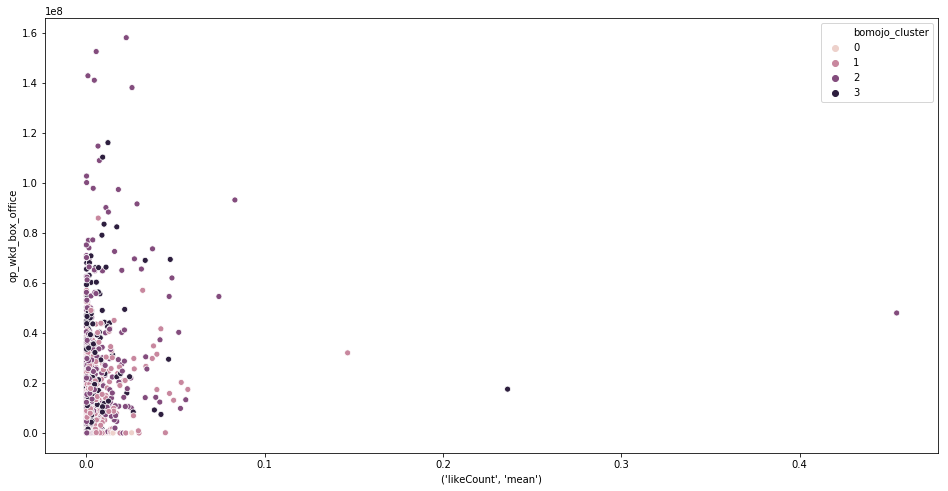

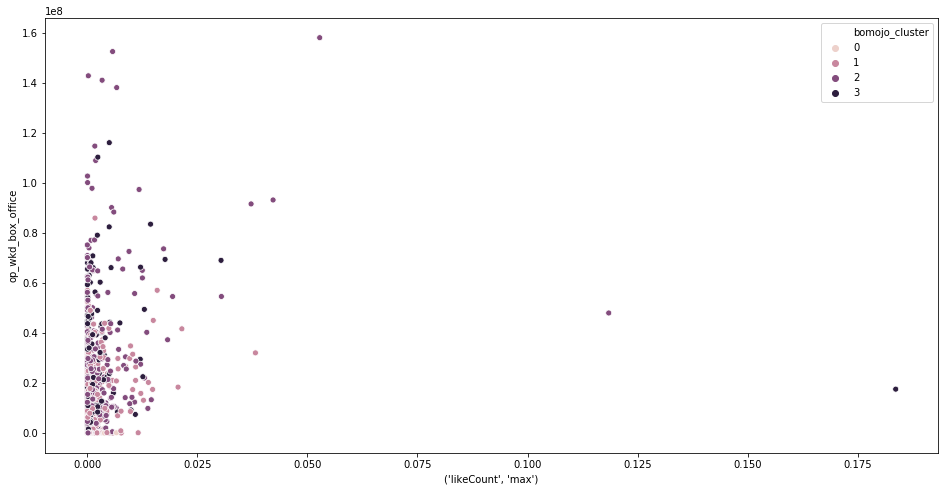

In [39]:
scatter_graph(df_bo_predictor,"('likeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('likeCount', 'max')",'op_wkd_box_office','bomojo_cluster')

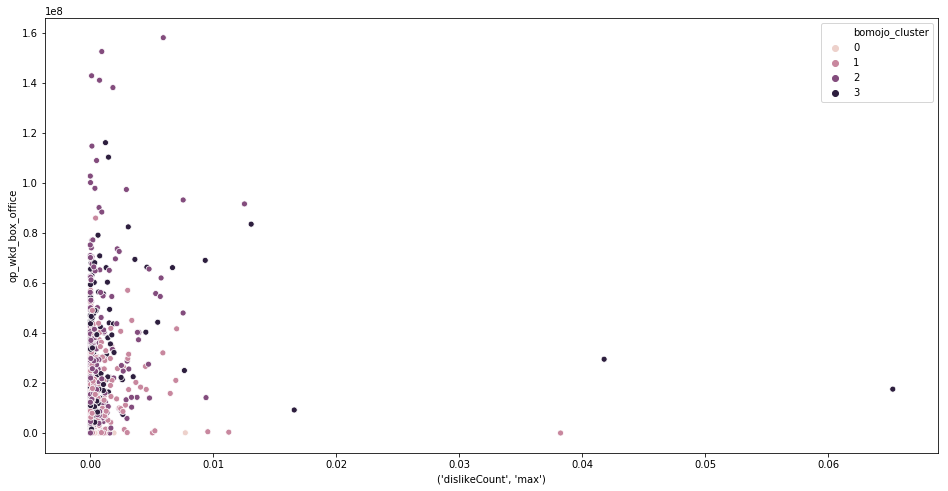

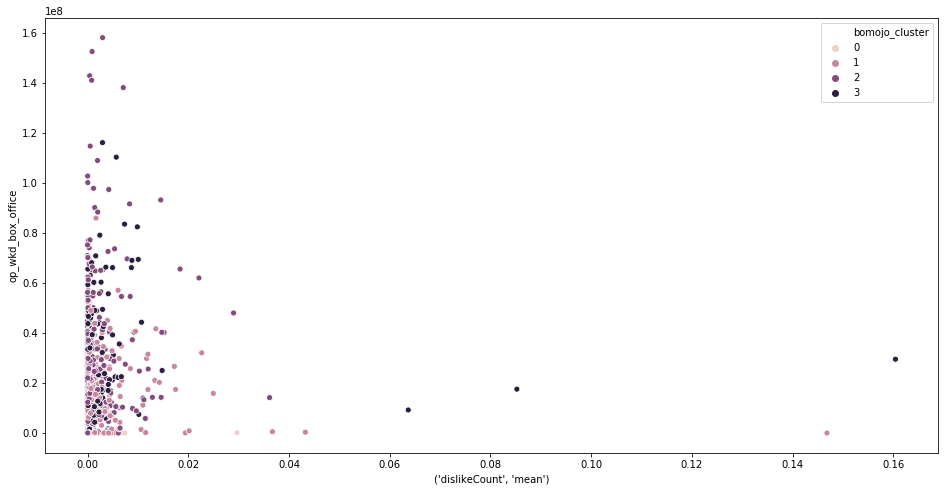

In [40]:
scatter_graph(df_bo_predictor,"('dislikeCount', 'max')",'op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

In [41]:
df_bo_predictor[df_bo_predictor["('dislikeCount', 'mean')"] > .03]["('dislikeCount', 'max')"].sort_values(ascending=False)

wiki_url
/wiki/The_Smurfs_2                            0.065243
/wiki/Justin_Bieber:_Never_Say_Never          0.041777
/wiki/The_Human_Centipede_(First_Sequence)    0.038234
/wiki/God%27s_Not_Dead_(film)                 0.016584
/wiki/Dear_White_People                       0.011262
/wiki/Venom_(2005_film)                       0.009559
/wiki/Scary_Movie_5                           0.009413
Name: ('dislikeCount', 'max'), dtype: float64

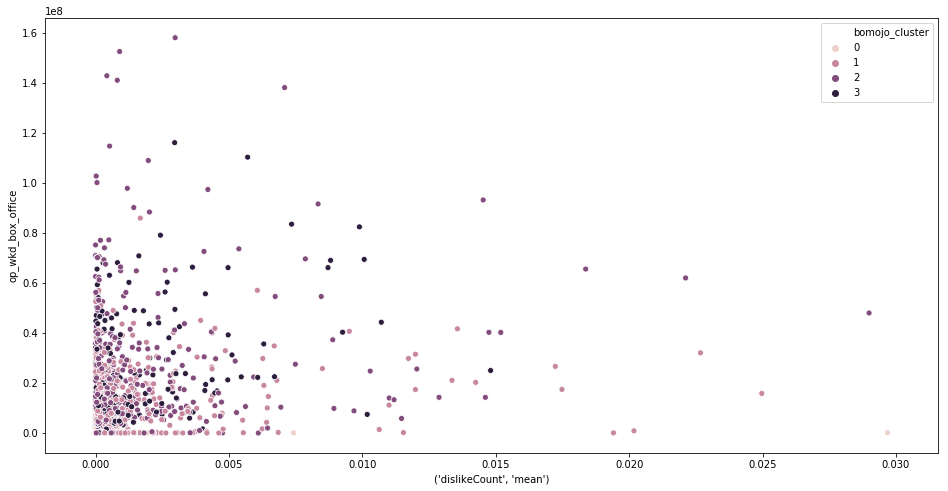

In [42]:
df_graph_test = df_bo_predictor[df_bo_predictor["('dislikeCount', 'mean')"] < .03]
scatter_graph(df_graph_test,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

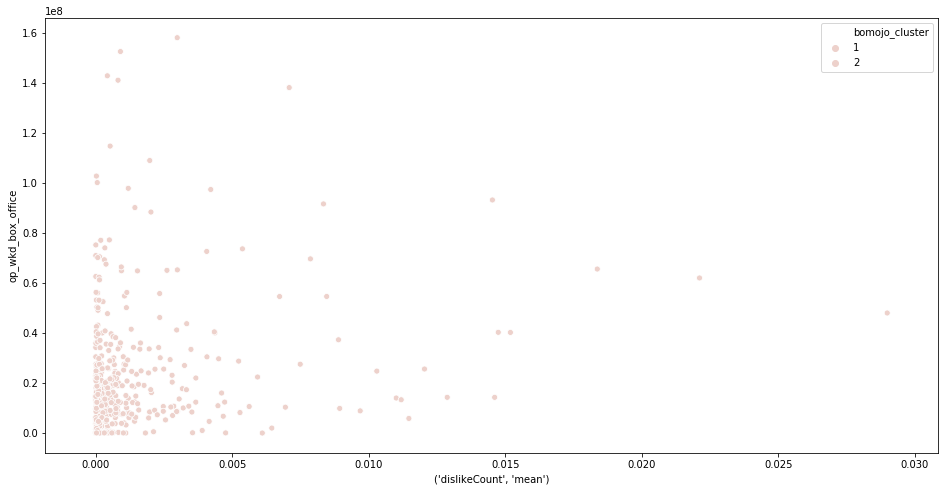

In [43]:
df_graph_test_2 = df_graph_test[df_graph_test['bomojo_cluster'] == 2]
scatter_graph(df_graph_test_2,"('dislikeCount', 'mean')",'op_wkd_box_office','bomojo_cluster')

In [44]:
# look at RT and MC scores related to tmdb scores
# RT and MC scores together to see if they're redundant, variance thresholds versus correlation thresholds

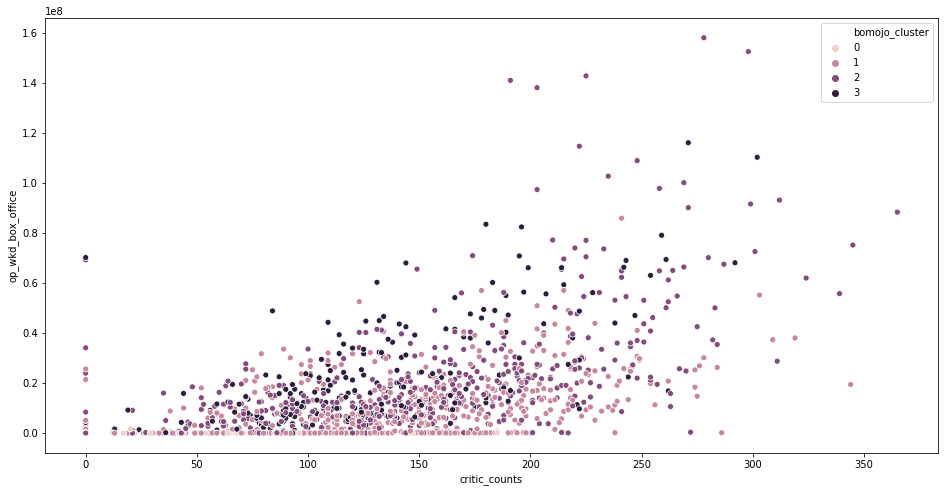

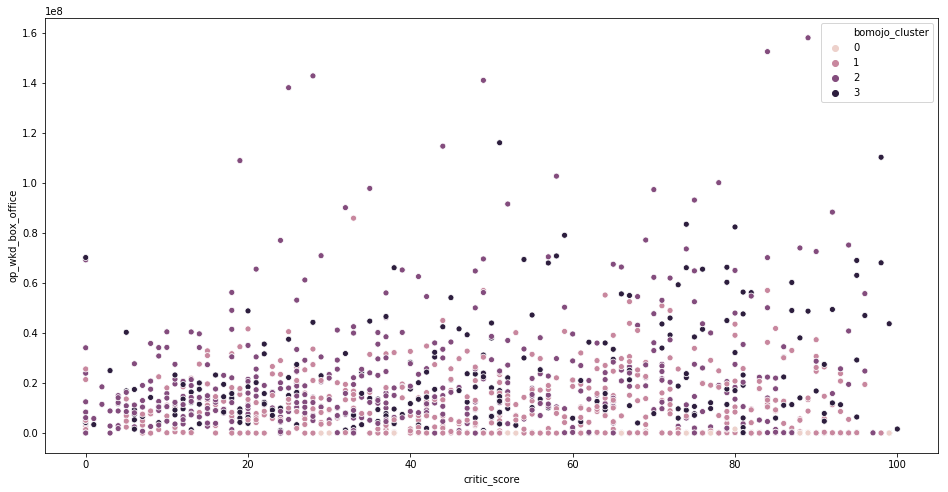

In [45]:
scatter_graph(df_bo_predictor,'critic_counts','op_wkd_box_office','bomojo_cluster')
scatter_graph(df_bo_predictor,'critic_score','op_wkd_box_office','bomojo_cluster')

Unfortunately, the RottenTomatoes website changed during the time in which I was scraping the website and running this model so when re-running the scraping process to account for 10+ years, I lost all of the audience score and counts. In future iterations I will need to fix this bug. However, for the time being, the popularity component I am capturing from RottenTomatoes is still preserved in the critic scores, i.e. more popular movies that are likely to receive more box office or commercial success have more critic reviews.

RottenTomatoes audience and critic counts a way better relationship with opening weekend box office than score.

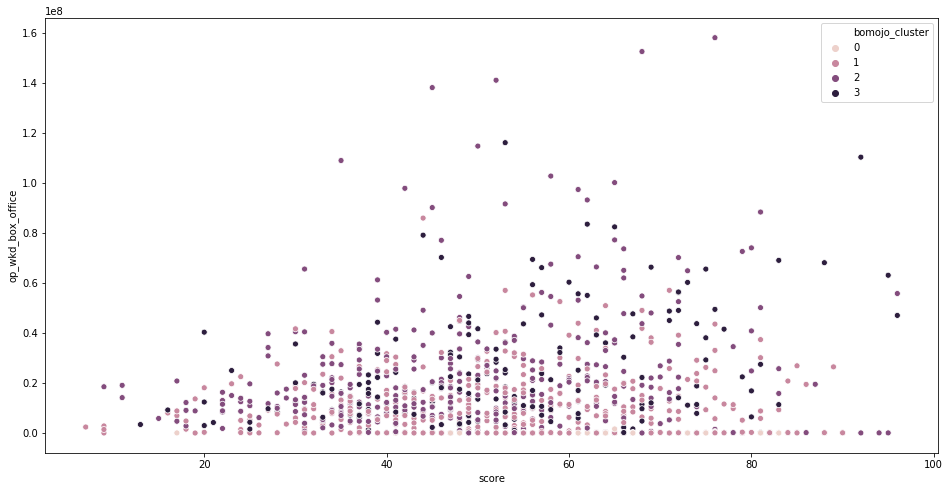

In [46]:
# mc score just like RT score doesn't seem as relevant
scatter_graph(df_bo_predictor,'score','op_wkd_box_office','bomojo_cluster')

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


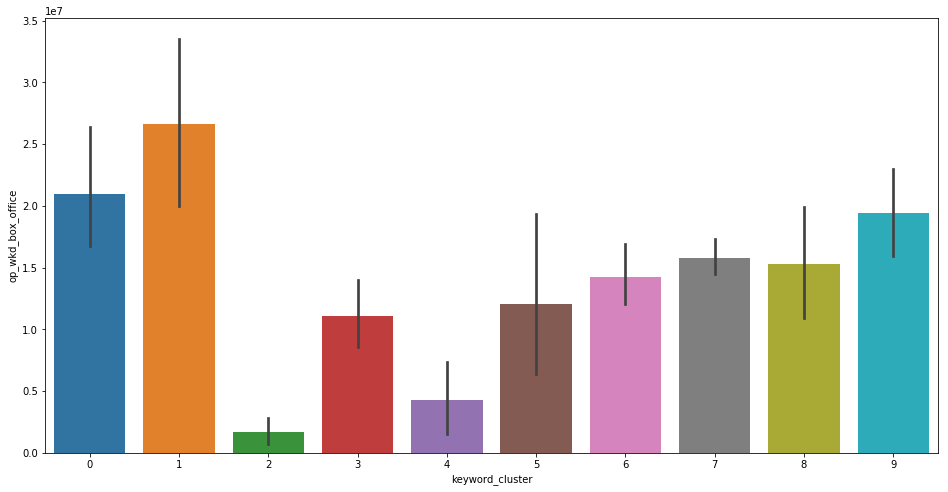

In [47]:
plt.figure(figsize=(16,8))
sns.barplot(x='keyword_cluster',y='op_wkd_box_office',data=df_bo_predictor)
plt.show()

### A quick look at film multiples

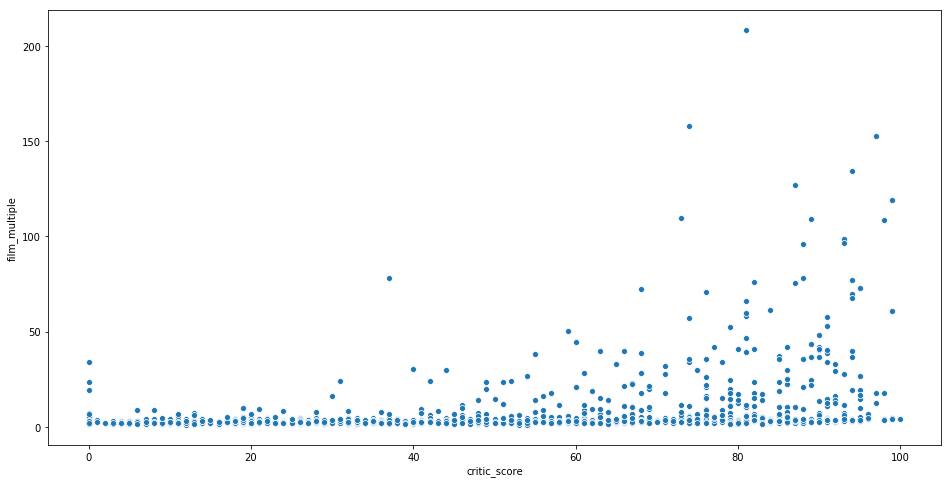

In [48]:
scatter_graph(df_bo_predictor,'critic_score','film_multiple',hue=None)

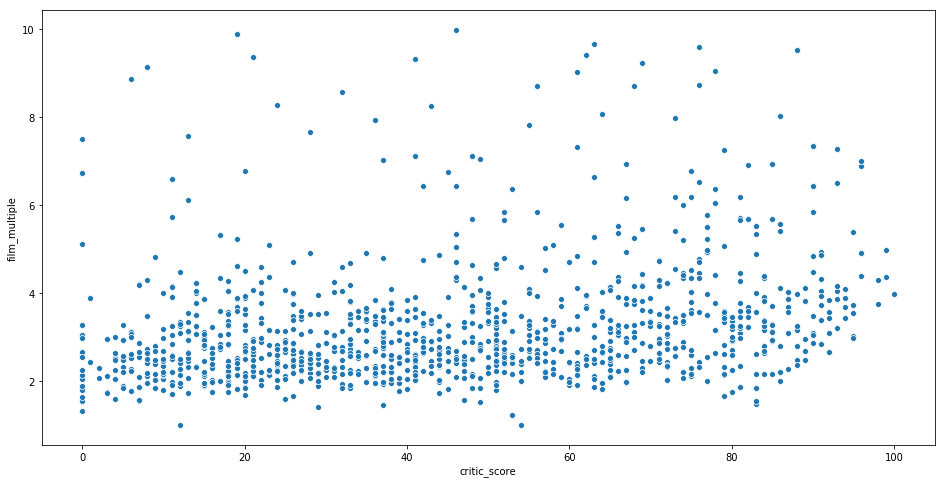

In [49]:
df_temp = df_bo_predictor[df_bo_predictor['film_multiple'] < 10]
scatter_graph(df_temp,'critic_score','film_multiple',None)

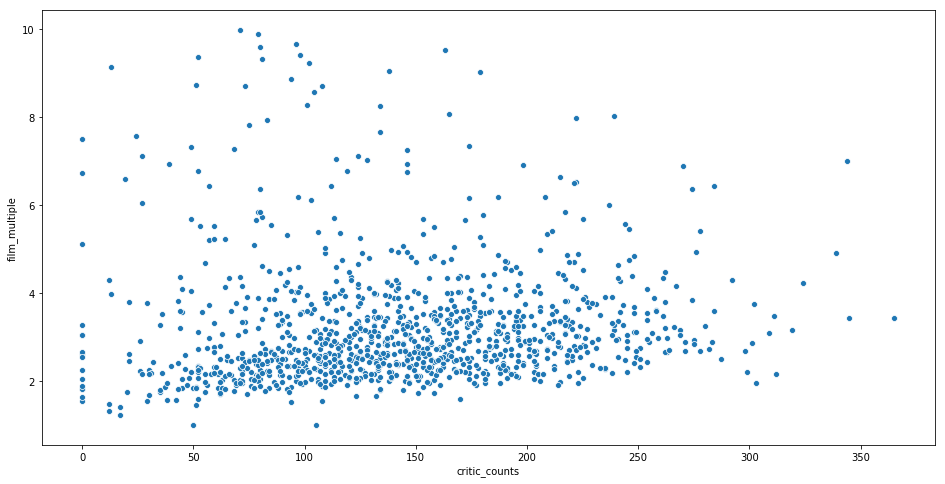

In [50]:
scatter_graph(df_temp,'critic_counts','film_multiple',None)

A little cleanup before modeling:

In [51]:
df_bo_predictor = df_bo_predictor.drop(['budget','popularity','release_date_x','runtime','aud_counts','aud_score',
                                        'url_x','url_y','bomojo_url','num_theaters','release_date_y','title',
                                        'release_date_clean'],axis=1)
# df_bo_predictor_wpv = df_bo_predictor_wpv.drop(['title_x','title_y','release_date_y','genre','url_x','runtime',
#                                             'release_date_x','budget','url_y','bomojo_url','aud_counts',
#                                             'aud_score'],axis=1)

### Linear Regression model

In [121]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','film_multiple','log_op_wkd_box_office'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('op_wkd_box_office',axis=1)
Y = df_model.op_wkd_box_office
X = pd.get_dummies(X)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [54]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [-1.77882266e+06  4.46760864e+03 -1.53363990e+07  5.18594106e+07
  6.97866078e+08  7.50947758e+08 -1.39352231e+08 -9.66420889e+07
 -1.36018182e+08  1.66829192e+08 -1.89733277e+07 -4.46683173e+07
 -8.15194212e+08  2.64854449e+09 -3.43288516e+08  1.84228805e+08
  3.08269165e+09 -3.70003682e+09  1.13770406e+09 -3.53588273e+06
  5.47163566e+06  7.07576800e+06 -1.42004541e+06  5.14421645e+05
 -2.66704766e+05 -5.94571398e+05  3.41895853e+06  1.63612852e+06
  5.39580913e+05 -8.59273076e+05 -5.50876486e+05  3.44289584e+05
 -1.44242601e+06  1.39169706e+06  1.60273165e-04  2.25489356e+06
  1.59667278e+05 -2.27896730e+06  8.20010900e-05 -5.82707285e+06
 -3.48704596e+06  1.71868181e+05 -3.06144823e+06  6.13935292e-04
 -6.55860684e+05 -7.98963010e-04 -2.39588320e-04 -1.06657891e+06
 -5.06083210e+05 -1.73090053e+06  2.79247761e-04 -2.65851617e-04
 -9.25183296e-04 -3.09541821e-04  2.27808952e-04  1.02220476e-03
 -3.31812758e+06  3.04825331e+06 -4.74914908e-04 -1.19104981e-04
  6.81027

In [55]:
y_pred = lr.predict(X_test)

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 10033257.962
Mean Squared Error: 221626090655313.156
Root Mean Squared Error: 14887111.562
Median Absolute Error: 2583.107


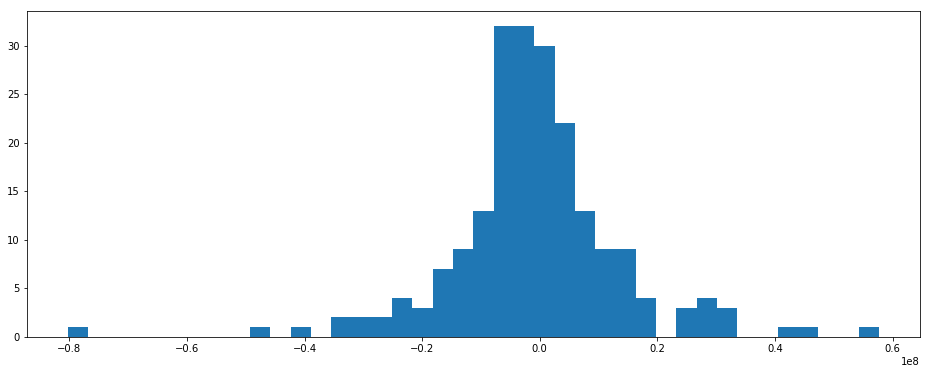

In [56]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [57]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [58]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10       8.984104
0.20      17.957181
0.25      23.005354
0.50      55.955050
0.75     173.047385
0.80     305.261908
0.85    2430.106704
0.90    9288.364675
Name: difference %, dtype: float64

### Random Forest Regressor

In [59]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
score = rfr.score(X_test, y_test)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.72926268763326


In [60]:
y_pred = rfr.predict(X_test)

print('Mean Absolute Error: %.f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 7242983.164
Mean Squared Error: 117257445829635.094
Root Mean Squared Error: 10828547.725
Median Absolute Error: 1992.217


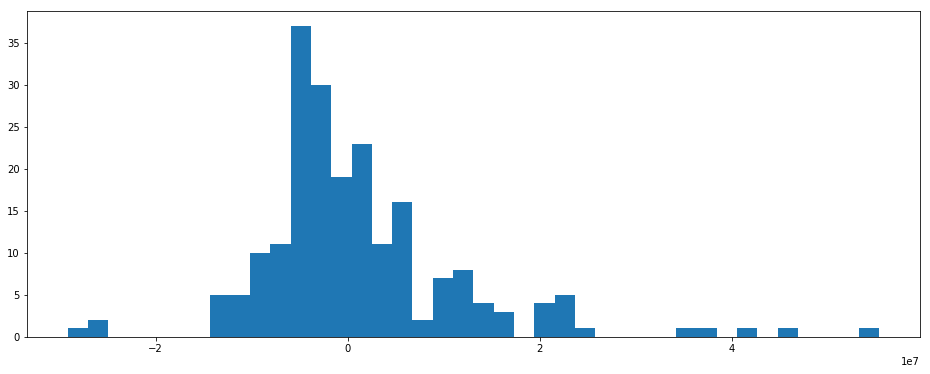

In [61]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [62]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [63]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10       8.272071
0.20      15.741712
0.25      19.793052
0.50      39.714617
0.75     107.818963
0.80     249.487199
0.85    3328.256383
0.90    8067.406019
Name: difference %, dtype: float64

### NN

I am using the log of the opening weekend box office because of the mean absolute error loss function does not perform well with non-scaled output data. 

In [125]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','film_multiple','op_wkd_box_office'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('log_op_wkd_box_office',axis=1)
Y = df_model.log_op_wkd_box_office
X = pd.get_dummies(X)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [127]:
# inputs first
input_shape = X_train.shape[1:]
num_classes = 1 # for regression problem

In [128]:
model = Sequential()

model.add(Dense(320,input_shape=input_shape,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(160, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
# Compile the model to put it all together.
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 320)               96960     
_________________________________________________________________
dropout_41 (Dropout)         (None, 320)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 160)               51360     
_________________________________________________________________
dropout_42 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 80)                12880     
_________________________________________________________________
dropout_43 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 40)                3240      
__________

In [129]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=5,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 834 samples, validate on 209 samples
Epoch 1/5
834/834 [==============================] - 1s 1ms/step - loss: 14.0756 - mean_absolute_error: 14.0756 - val_loss: 14.4742 - val_mean_absolute_error: 14.4742
Epoch 2/5
834/834 [==============================] - 0s 119us/step - loss: 14.0756 - mean_absolute_error: 14.0756 - val_loss: 14.4742 - val_mean_absolute_error: 14.4742
Epoch 3/5
834/834 [==============================] - 0s 123us/step - loss: 14.0756 - mean_absolute_error: 14.0756 - val_loss: 14.4742 - val_mean_absolute_error: 14.4742
Epoch 4/5
834/834 [==============================] - 0s 120us/step - loss: 14.0756 - mean_absolute_error: 14.0756 - val_loss: 14.4742 - val_mean_absolute_error: 14.4742
Epoch 5/5
834/834 [==============================] - 0s 116us/step - loss: 14.0756 - mean_absolute_error: 14.0756 - val_loss: 14.4742 - val_mean_absolute_error: 14.4742
Test loss: 14.474244355014637
Test accuracy: 14.474244355014637


In [130]:
print('Non-log mean absolute error, test loss: %0.f' % np.exp(score[0]))
print('Non-log mean absolute error, test accuracy: %0.f' % np.exp(score[1]))

Non-log mean absolute error, test loss: 1932344
Non-log mean absolute error, test accuracy: 1932344


## Film Multiple model
### Linear regression to predict film multiple

In [89]:
# linear regression for box office results
df_model = df_bo_predictor.drop(['dom_box_office','op_wkd_box_office','log_op_wkd_box_office'],axis=1)
df_model = df_model.dropna()
X = df_model.drop('film_multiple',axis=1)
Y = df_model.film_multiple
X = pd.get_dummies(X)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

In [91]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)
print('R-squared: \n', lr.score(X_train, y_train))

Coefficients: 
 [ 1.71132132e+00 -3.49089325e-04  1.80092578e+00 -7.07797086e+01
 -2.31958830e+03  2.36956018e+03 -9.12958613e+01 -2.04063115e+01
 -6.20568001e+00  2.03146438e+01  2.10130443e+01  1.35296109e+02
  2.26555098e+03 -5.77058179e+02 -1.39175749e+02  1.06017254e+02
  4.35702100e+02 -9.43784689e+02  2.58849393e+02  6.63738176e-01
  1.20596825e+00  3.29658109e+00  1.38020515e+00  2.27223797e-01
  5.03170101e+01  2.65075835e-01 -2.04826812e-01 -1.43878916e+00
  3.09031129e+00  3.39966732e+00  6.45859168e+00  1.97033699e+00
  1.14329429e+00 -3.75721976e+00 -5.91631633e-10 -3.42052855e+00
 -5.70775443e+00 -1.46697815e+00 -1.10430332e-09  2.91320622e+00
  1.49165867e+00  4.86081422e+01  7.02550689e+00 -9.58910285e-10
  1.10226455e+01  6.54198917e-11 -2.54502197e-10  2.09072501e+00
  3.69316402e+00  1.70700942e+01  2.33989716e-10  2.32144970e-10
  7.32754302e-10  3.10024006e-10 -3.58024721e-10  2.80177659e-10
  7.91731078e+00  1.32722363e+01  8.21540169e-10  1.08970255e-09
 -1.99918

In [92]:
y_pred = lr.predict(X_test)

print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 7.158
Mean Squared Error: 147.195
Root Mean Squared Error: 12.132
Median Absolute Error: 1.988


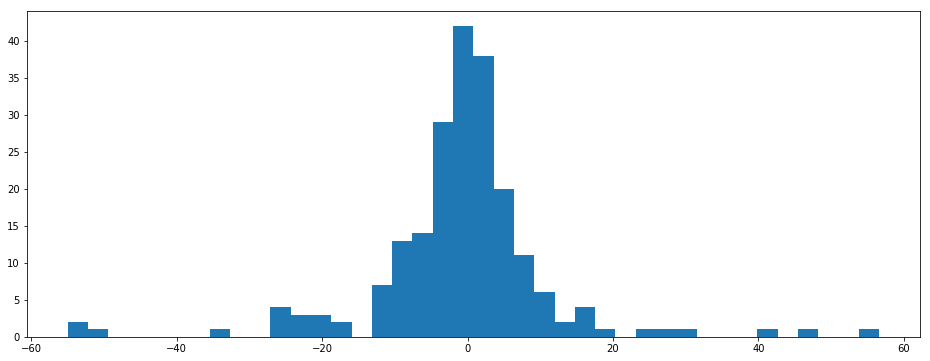

In [93]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [94]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [95]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10     17.138826
0.20     35.032669
0.25     43.135502
0.50     91.164191
0.75    203.764336
0.80    260.326578
0.85    317.449428
0.90    391.619181
Name: difference %, dtype: float64

### Random Forest Regressor

In [96]:
rfr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
rfr.fit(X_train, y_train)
score = rfr.score(X_test, y_test)
print(f'Accuracy score for random forest regressor: {score}')

Accuracy score for random forest regressor: 0.4919813098068179


In [97]:
y_pred = rfr.predict(X_test)

print('Mean Absolute Error: %.3f' % metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error: %.3f' % metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error: %.3f' % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Median Absolute Error: %.3f' % np.sqrt(metrics.median_absolute_error(y_test, y_pred)))

Mean Absolute Error: 3.411
Mean Squared Error: 59.727
Root Mean Squared Error: 7.728
Median Absolute Error: 0.909


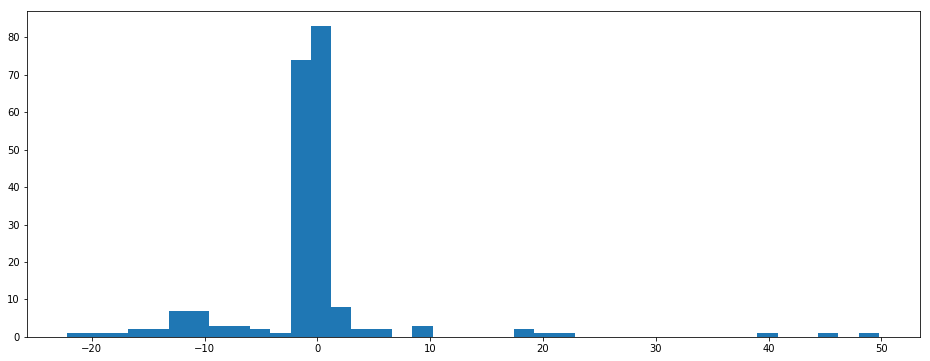

In [98]:
plt.figure(figsize=(16,6))
plt.hist(y_test - y_pred, bins=40)
plt.show()

In [99]:
# for comparison when using log box office
compare_df = pd.DataFrame({'actual_boxoffice':y_test,
                          'predicted_boxoffice':y_pred},
                         columns=['actual_boxoffice','predicted_boxoffice'])

compare_df['difference'] = abs(compare_df['actual_boxoffice'] - compare_df['predicted_boxoffice'])
compare_df['difference %'] = abs(compare_df['predicted_boxoffice'] / compare_df['actual_boxoffice'] - 1) * 100

# look at instances where we predicted greater or less than 75% of actual box office, try to fix
big_misses = compare_df[compare_df['difference %'] > 100]

In [100]:
compare_df['difference %'].quantile([.1,.2,.25,.5,.75,.8,.85,.9])

0.10     4.876610
0.20     8.783273
0.25    12.221891
0.50    26.443515
0.75    49.921675
0.80    57.147375
0.85    63.670548
0.90    96.054830
Name: difference %, dtype: float64